# 02 Machine Learning

## Proyecto: Credit Card Leads

### Equipo:
- Javier De La Rosa Mondragon
- Luis Fernando Merino Nambo
- Salomon Ramírez

![Leads](credit-cards.jpg)

###  Dataset

Credit Card Lead Prediction

https://www.kaggle.com/datasets/shelvigarg/credit-card-buyers

- ~250,000 filas en train set

- ~100,000 etiquetas en test set

- 10 Features
    - ID
    - Sexo
    - Edad
    - Region
    - Ocupación
    - Channel code
    - Vintage
    - Credit product
    - Balance promedio
    - Activo
    


- 1 Columna de target
    - Lead

## Objetivo

Analizar, limpiar y usar el train dataset para identificar clientes con tendencia a adquirur una tarjeta de crédito tomando como features los datos del cliente y los productos con los que ya cuentan.


## Importación de bibliotecas 

In [1]:
# VARIABLES DE EJECUCIÓN
DATA_FRACTION = 1 # parte del dataset completo de datos a utlizar
LONG_TIME_CELLS = False # ejecutar las celdas de EDA que tardan mucho
SMOTE_FRACTION = .1 # parte del dataset sobremuestreado a utlizar
DATA_TO_USE = 'over' # 'over' | 'sub' | 'orig'  # los datos que se usarán en el entrenamiento final

In [68]:
# numerical y Dfs
import pandas as pd
import numpy as np

# ML:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, VarianceThreshold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2 # selección de features categoricas
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN

# SMOTE oversamplig
from imblearn.over_sampling import SMOTE

# árboles de decisión
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# visualización de árboles con dtreeviz
from sklearn import tree
#from dtreeviz import model
from dtreeviz.trees import *

# visualización de árboles con graphviz
from sklearn.tree import export_graphviz
from six import StringIO  
from IPython.display import Image  
import pydotplus

# métricas de rendimiento
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# visualización
import seaborn as sns
from matplotlib import pyplot as plt

# timing operations
import time

In [3]:
# paletas para seaborn
palQualitative = ['#fbb4ae','#b3cde3','#ccebc5','#decbe4','#fed9a6','#ffffcc','#e5d8bd','#fddaec','#f2f2f2']
palPaired = sns.color_palette("Accent")
sns.set()
sns.set_palette( palQualitative )

In [4]:
def printTime(msg='time_now:',hours=1,mins=53):
    '''imprime la hora corregida porque el servidor la tiene mal'''
    current_time = time.localtime()
    new_time = current_time.tm_min - mins
    new_time = new_time % 60
    print(msg, f" {current_time.tm_hour-hours:02d}:{new_time:02d}:{current_time.tm_sec:02d}")

## Lectura de datos

In [5]:
data = pd.read_csv('./data/train data credit card.csv')
print('Full Data size:',data.shape)

Full Data size: (245725, 11)


In [6]:
data.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,NNVBBKZB,Female,73,RG268,Other,X3,43,No,1045696,No,0
1,IDD62UNG,Female,30,RG277,Salaried,X1,32,No,581988,No,0
2,HD3DSEMC,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,0
3,BF3NC7KV,Male,34,RG270,Salaried,X1,19,No,470454,No,0
4,TEASRWXV,Female,30,RG282,Salaried,X1,33,No,886787,No,0


## Limpieza y EDA

In [7]:
display(data.isna().sum())
print(data.shape)

ID                         0
Gender                     0
Age                        0
Region_Code                0
Occupation                 0
Channel_Code               0
Vintage                    0
Credit_Product         29325
Avg_Account_Balance        0
Is_Active                  0
Is_Lead                    0
dtype: int64

(245725, 11)


In [8]:
# limpieza de datos del set de entrenamiento
# ya que el dataset es muy grande, empezaremos eliminando las filas con datos vaciós
data = data.dropna()
data.reset_index(inplace=True,drop=True)
display(data.isna().sum().sum())
print(data.shape)

0

(216400, 11)


In [9]:
def create_piechart_with_values(data, title, ax, optional_names=None):
    df = data
    value_counts = df.value_counts()
    category_counts = df.value_counts().values
    patches, texts, autotexts = ax.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%')

    total = sum(value_counts.values)
    label_values = []
    if optional_names:
        value_counts.index = optional_names
        
    for n,v in zip(value_counts.index,value_counts.values):
        v = f'{v:,}'
        #label_values.append(    f'{n}: {v} ({(v / total) * 100:.1f}%)'    )
        label_values.append(    f'{n}: {v}'    )
    
    for i, text in enumerate(texts):
        text.set_text(label_values[i])
    
    ax.set_title(title)

### Variables Categóricas

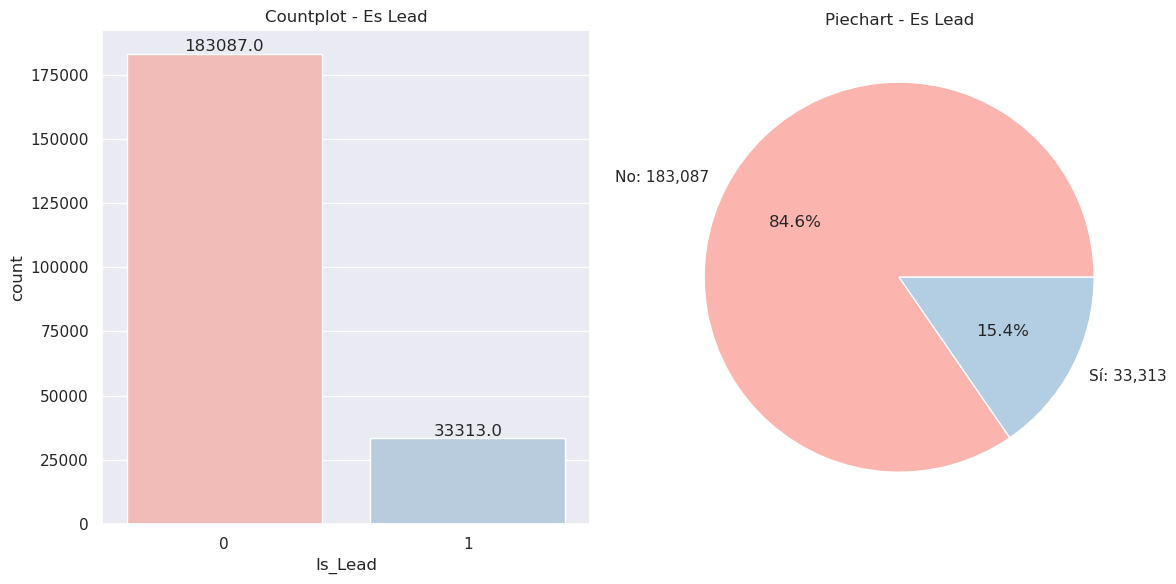

In [10]:
# ya que trabajaremos con clasificación, veamos cuántos casos hay de cada categoría:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

sns.countplot(x=data.Is_Lead, ax=ax1)
ax1.set_title('Countplot - Es Lead')

for p in ax1.patches:
    ax1.annotate(format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', xytext = (0, 5), textcoords = 'offset points')

create_piechart_with_values(data.Is_Lead, 'Piechart - Es Lead',ax2,['No','Sí'])    

plt.tight_layout()
plt.show()


In [11]:
# Observamos que hay una deproporción muy grande.

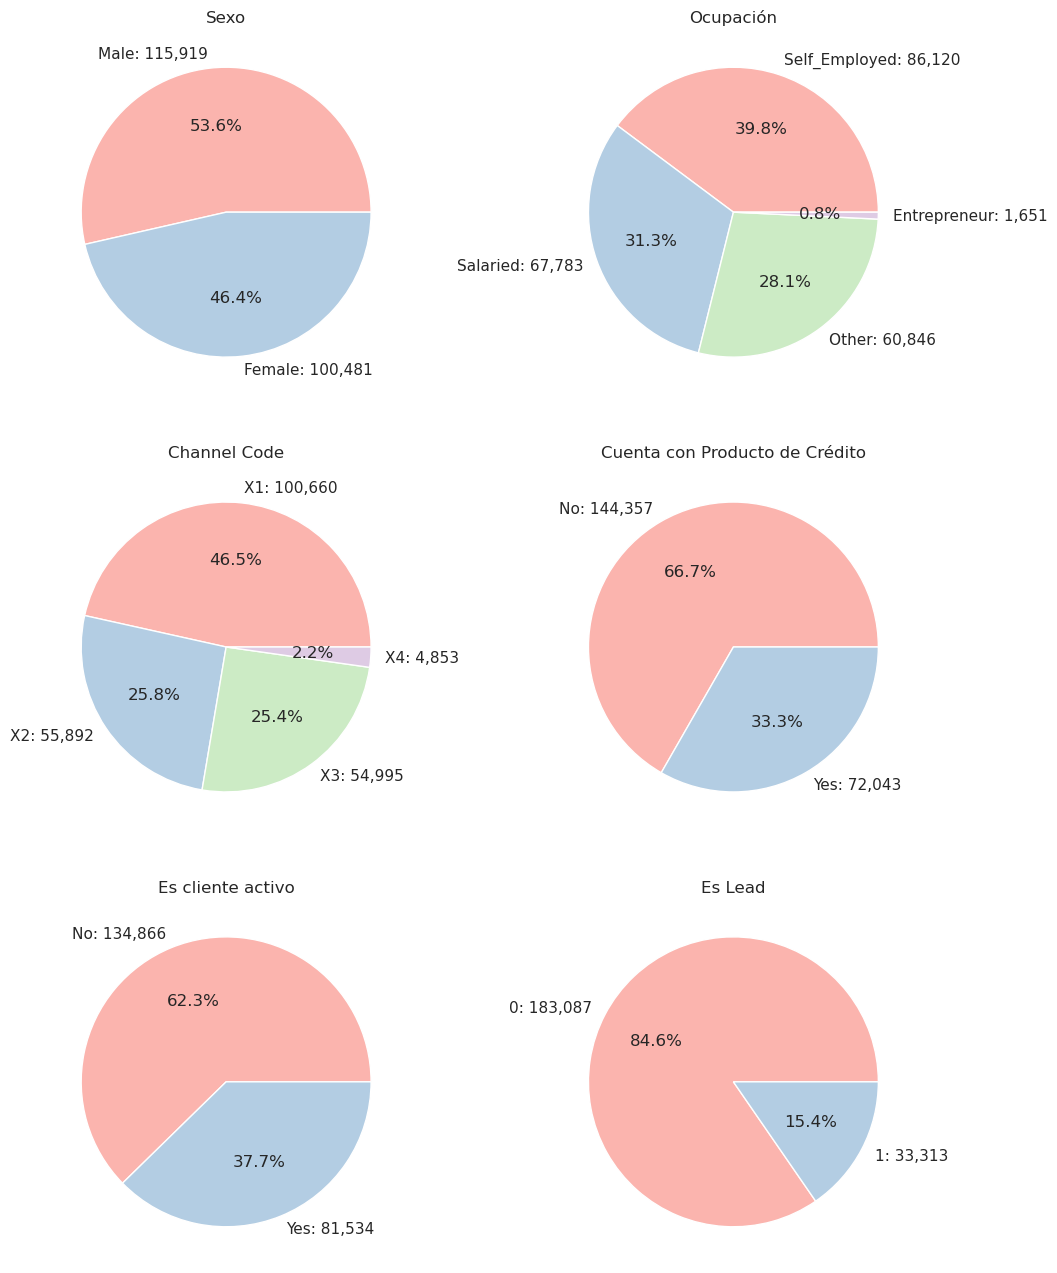

In [12]:
# Veamos las distribuciones de algunas variables:
fig, axes = plt.subplots(3, 2, figsize=(12, 16))

#sns.countplot(data=creditCardLeadDf, x='Gender', ax=axes[0])
#axes[0].set_title('Sexo')
#sns.countplot(data=creditCardLeadDf, x='Is_Active', ax=axes[0])
#axes[0].set_title('Es cliente activo')
#sns.countplot(data=creditCardLeadDf, x='Credit_Product', ax=axes[1])
#axes[1].set_title('Cuenta con Producto de Crédito')
#sns.countplot(data=creditCardLeadDf, x='Occupation', ax=axes[1])
#axes[1].set_title('Ocupación')

create_piechart_with_values(data.Gender, 'Sexo',axes[0][0])
create_piechart_with_values(data.Occupation, 'Ocupación',axes[0][1])
create_piechart_with_values(data.Channel_Code, 'Channel Code',axes[1][0])
create_piechart_with_values(data.Credit_Product, 'Cuenta con Producto de Crédito',axes[1][1])
create_piechart_with_values(data.Is_Active, 'Es cliente activo',axes[2][0])
create_piechart_with_values(data.Is_Lead, 'Es Lead',axes[2][1])

#plt.tight_layout()
plt.show()

Hay 35 valores distintos de Region_Code


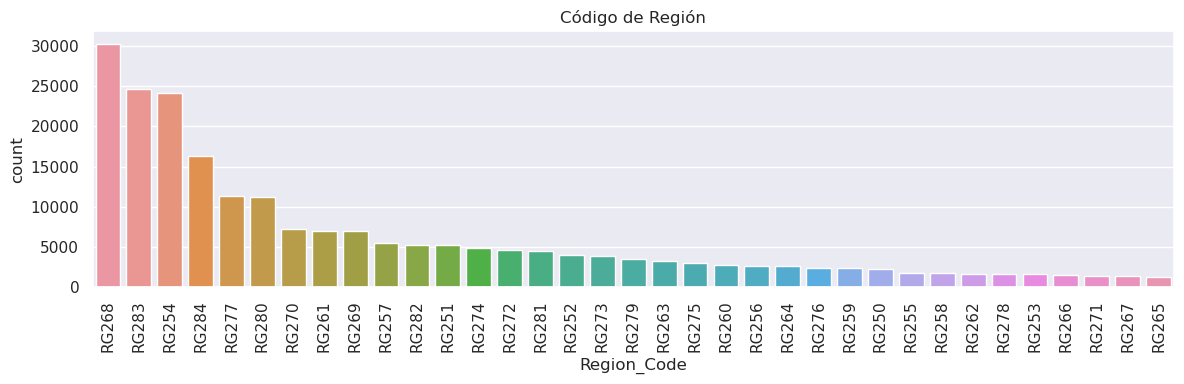

In [13]:
# Veamos las proporciones en algunas variables:
print('Hay',data.Region_Code.value_counts().shape[0],'valores distintos de Region_Code')

fig, axes = plt.subplots(1, 1, figsize=(12, 4))
sns.countplot(data=data.sort_values(by='Region_Code'), x='Region_Code', ax=axes, order = data['Region_Code'].value_counts().index)
axes.set_xticklabels(axes.get_xticklabels(), rotation=90)
axes.set_title('Código de Región')
plt.tight_layout()

# Show the plot
plt.show()

Veremos más adelante si esta variable es relevante para la clasificación


### Variables Numéricas

Veamos histogramas y boxplots para las dos variables numéricas que tienen nuestros datos

In [14]:
def createHist(data,titulo,nobins=None):
    fig, axes = plt.subplots(2, 1, figsize=(12, 4))
    #data = creditCardLeadDf['Avg_Account_Balance']
    #titulo = 'Balance Promedio'

    if nobins:
        sns.histplot(data,ax=axes[0],bins= (data.max()-data.min()) )
    else:
        sns.histplot(data,ax=axes[0] )
    axes[0].set_xlabel('Values')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title(titulo+' - Histograma')

    sns.boxplot(x=data, ax=axes[1])
    mean_value = np.mean(data)
    axes[1].plot(mean_value, 0,  marker='o', color='red', label='Mean')
    axes[1].text(mean_value+mean_value/1.5, -.3, f"Mean: {mean_value:.2f}", color='teal', ha='left', va='center')
    #axes[1].set_xlabel('Values')
    #axes[1].set_ylabel('Count')
    axes[1].set_title(titulo+' - Boxplot')
    #axes[1].legend()


    plt.tight_layout()
    plt.show()


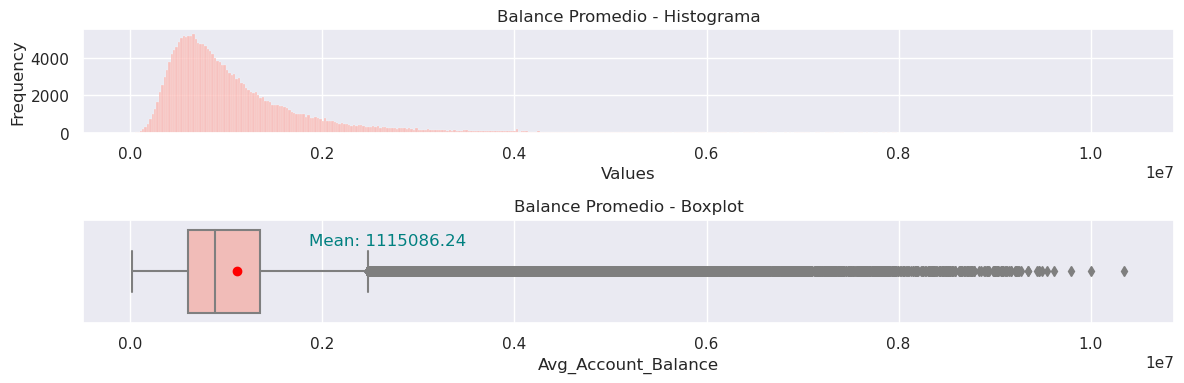

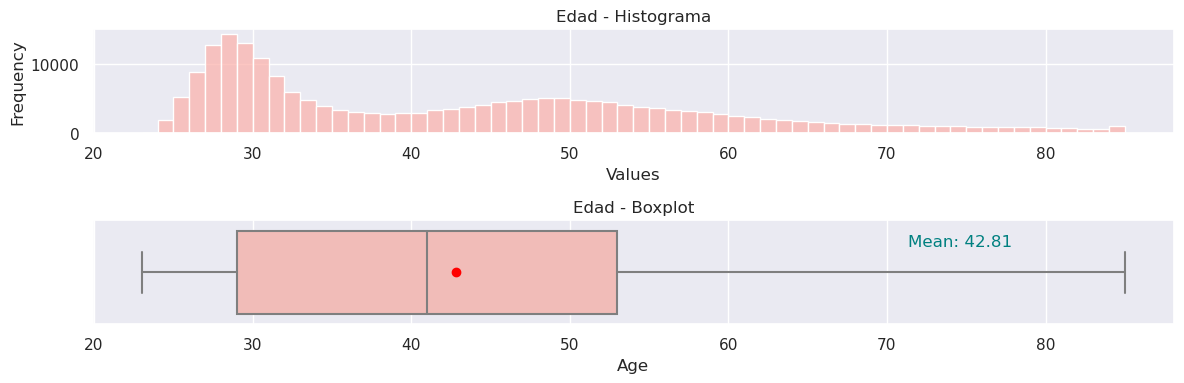

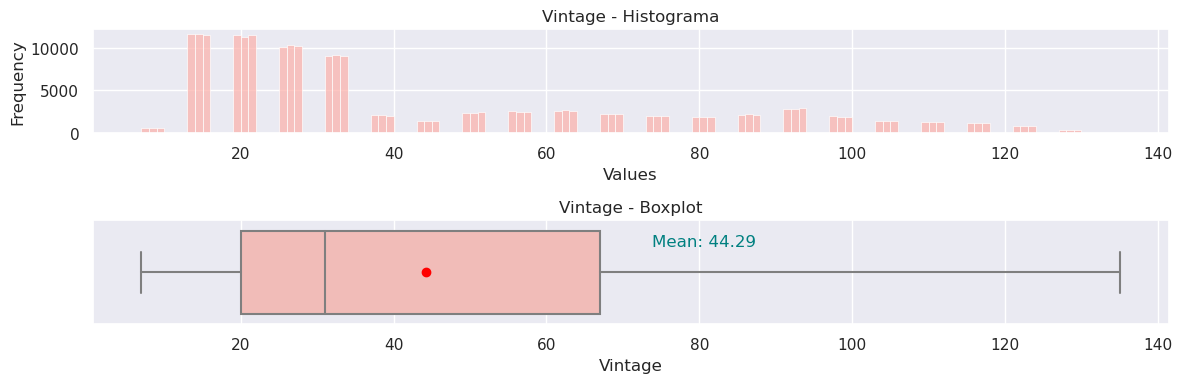

In [15]:
#sns.set_palette( palQualitative )
createHist(data['Avg_Account_Balance'],'Balance Promedio')
createHist(data['Age'],'Edad',nobins=True)
createHist(data['Vintage'],'Vintage',nobins=True)

In [16]:
# ya que la columna ID no aporta nada a la clasificación, la eliminaremos
data = data.drop('ID', axis=1)

In [17]:
data.head()

,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,Female,73,RG268,Other,X3,43,No,1045696,No,0
1,Female,30,RG277,Salaried,X1,32,No,581988,No,0
2,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,0
3,Male,34,RG270,Salaried,X1,19,No,470454,No,0
4,Female,30,RG282,Salaried,X1,33,No,886787,No,0


### Conversión de variables a one-hot encoding

In [18]:
# las siguientes columnas puedes ser codificadas como one-hot:
# Gender (2 valores), Region_Code (35), Occupation (4), Channel_Code (4), Credit_Product (2), Is_Active (2)

In [19]:
# Codificamos en one-hot:
toOneHot = ['Gender', 'Occupation', 'Is_Active', 'Credit_Product','Channel_Code', 'Region_Code']
data = pd.get_dummies(data,columns=toOneHot)
print(data.shape)
display(data)

(216400, 53)


,Age,Vintage,Avg_Account_Balance,Is_Lead,Gender_Female,Gender_Male,Occupation_Entrepreneur,Occupation_Other,Occupation_Salaried,Occupation_Self_Employed,...,Region_Code_RG275,Region_Code_RG276,Region_Code_RG277,Region_Code_RG278,Region_Code_RG279,Region_Code_RG280,Region_Code_RG281,Region_Code_RG282,Region_Code_RG283,Region_Code_RG284
0,73,43,1045696,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,30,32,581988,0,1,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
2,56,26,1484315,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,34,19,470454,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,30,33,886787,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216395,38,13,354665,0,1,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
216396,27,15,862952,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
216397,26,13,670659,0,1,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
216398,28,31,407504,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
# Para las variables que originalmente eran binarias, podemos eliminar una de sus
# dos columnas provenientes de get_dummies (Gender, Is_Active, ):
print(data.shape)
data = data.drop(['Gender_Female','Is_Active_No','Credit_Product_No'], axis=1)
print(data.shape)

(216400, 53)
(216400, 50)


In [21]:
# Tratemos de ver correlación entre las variables de Channel_Code y la salida
x_vars = [ x for x in list(data) if 'Channel_Code' in x] 
graphsPerRow = len(x_vars)
assert len(x_vars) % graphsPerRow == 0,f'usa un múltiplo de {len(x_vars)} para el número de gráficas por fila'
for i in range(int(len(x_vars)/graphsPerRow)):
    if LONG_TIME_CELLS:
        graph = sns.pairplot(data, x_vars=x_vars[i*graphsPerRow:i*graphsPerRow+graphsPerRow], y_vars='Is_Lead', height=5, aspect=1, kind='reg')
        graph.fig.suptitle('Correlación Channel-Salida', y=1.08)
    plt.show()

# Observaciones:    
# Parece que por lo menos las tres primeras sí tienen un efecto en la salida
# Aquí podría parecer que el chanel X4 es el menos efectivo obteniendo leads

In [22]:
# Tratemos de ver correlación entre las variables de Occupation y la salida
x_vars = [ x for x in list(data) if 'Occupation' in x] 
graphsPerRow = len(x_vars)
assert len(x_vars) % graphsPerRow == 0,f'usa un múltiplo de {len(x_vars)} para el número de gráficas por fila'
for i in range(int(len(x_vars)/graphsPerRow)):
    if LONG_TIME_CELLS:
        graph = sns.pairplot(data, x_vars=x_vars[i*graphsPerRow:i*graphsPerRow+graphsPerRow], y_vars='Is_Lead', height=5, aspect=1, kind='reg')
        graph.fig.suptitle('Correlación Ocupación-Salida', y=1.08)
    plt.show()

# Observaciones:    
# Vemos que de entre las 4, Occupation_Entrepreneur es la que tiene más efecto sobre la salida

In [23]:
# Tratemos de ver correlación entre nuestras variables numéricas y la salida:
x_vars = ['Age','Avg_Account_Balance','Vintage'] 
graphsPerRow = len(x_vars)
assert len(x_vars) % graphsPerRow == 0,f'usa un múltiplo de {len(x_vars)} para el número de gráficas por fila'
for i in range(int(len(x_vars)/graphsPerRow)):
    if LONG_TIME_CELLS:
        graph = sns.pairplot(data, x_vars=x_vars[i*graphsPerRow:i*graphsPerRow+graphsPerRow], y_vars='Is_Lead', height=5, aspect=1, kind='reg')
        graph.fig.suptitle('Correlación Variables Numéricas-Salida', y=1.08)
    plt.show()
    
# Observaciones:
# Vemos que de las tres tienen cierto grado apreciable de correlación con la salida

In [24]:
# Y ahora veamos la correclación entre esas tres variables
#sns.pairplot(data, vars=x_vars, hue='Is_Lead', markers = ['d','v'], kind = "hist", diag_kind = None)
if LONG_TIME_CELLS:
    sns.pairplot(data, vars=x_vars, hue='Is_Lead', kind = "hist", diag_kind = 'kde')

# Observaciones:
# No encotramos mucha correlación entre éstas

In [25]:
# También vemos la correlación entre estas variables usando Spearman
display(data[x_vars].corr(method="spearman"))

# Observaciones:
# Se observa una correlación significativa entre Age y Vintage, lo cual es de esperarse porque
# sólo la gente de mayor edad puede tener más historial crediticio
# (Yo esperaba encontrar más correlación entre edad y balance)

,Age,Avg_Account_Balance,Vintage
Age,1.000000,0.168859,0.655250
Avg_Account_Balance,0.168859,1.000000,0.184243
Vintage,0.655250,0.184243,1.000000


In [26]:
# Tratemos de ver correlaciones entre las variables de región y la salida
x_vars = list(data)
x_vars = [ x for x in x_vars if 'Region' in x] 

#print(x_vars)
#print(len(x_vars))

graphsPerRow = 5

assert len(x_vars) % graphsPerRow == 0,f'usa un múltiplo de {len(x_vars)} para el número de gráficas por fila'

if LONG_TIME_CELLS:
    for i in range(int(len(x_vars)/graphsPerRow)):
        sns.pairplot(data, x_vars=x_vars[i*graphsPerRow:i*graphsPerRow+graphsPerRow], y_vars='Is_Lead', height=5, aspect=1, kind='reg')
        plt.show()

# Observaciones:
# No notamos que alguna región destaque

In [27]:
# Veamos si hay otras correlaciones entre nuestras variables:
thres = .4
corrs = data.corr(method="spearman")
print(f'Spearman > {thres}:')
print(f'-------------------------')
moreCorr = []
for i, row in corrs.iterrows():
    for ic,val in zip(list(data),row):
        if val>thres and i!=ic:
            if val>=.4 and val<.69:
                note = 'Moderate Correlation'
            elif val>.7 and val<.89:
                note = 'Strong Correlation'
            elif val>=.9:
                note = 'Very Strong Correlation'
                
            variablesCorrelacionadas = [i,ic]
            variablesCorrelacionadas.sort()
            text = ' - '.join(variablesCorrelacionadas)
            moreCorr.append(f' {text} : {str(round(val,3))} ({note})')

moreCorr=list(set(moreCorr))
moreCorr.sort()
for i in moreCorr:
    print(i)

Spearman > 0.4:
-------------------------
 Age - Channel_Code_X3 : 0.474 (Moderate Correlation)
 Age - Vintage : 0.655 (Moderate Correlation)
 Channel_Code_X1 - Occupation_Salaried : 0.603 (Moderate Correlation)
 Channel_Code_X3 - Vintage : 0.484 (Moderate Correlation)


### Observaciones:
Se nota una correlación moderada entre Channel_Code_X3 y  Vintage (pudo ser que ese canal se enfocó en ciertos clientes con mucha o poca antiguedad).

También moderada de ese mismo canal y la edad de los clientes.

Y correlaciones un poco más fuertes entre el canal X1 y clientes asalariados.

Desde luego, la correlación que ya habiamos notado entre edad y vintage (historial crediticio).

### Sampling para entrenar y copia de datos completos

In [28]:
dataFull = data.copy()
X_full = dataFull.drop('Is_Lead',axis=1)
y_full = dataFull['Is_Lead']

In [29]:
# Ejecutar desde aquí para diferentes pruebas con fracciones de los datos originales
data = dataFull.sample(frac=DATA_FRACTION)
data.reset_index(inplace=True,drop=True)

print("Fracción de datos utlizados para entrenamiento:", DATA_FRACTION*100,'%')
print('Train Data size:',data.shape)
print('Full Data size:',dataFull.shape)

Fracción de datos utlizados para entrenamiento: 100 %
Train Data size: (216400, 50)
Full Data size: (216400, 50)


### Primer splitting para entrenar

In [30]:
X = data.drop('Is_Lead',axis=1)
y = data['Is_Lead']

## Selección de features con SelectKBest

In [31]:
# Selección de Features con Threshold fue descartada debido al alto número de variables categpóicas
best=10
selector = SelectKBest(k=best,score_func=chi2)

#scaler = MinMaxScaler()
#XScaled = scaler.fit_transform(X)
#XScaled = pd.DataFrame(data=XScaled, columns=list(X))

selector.fit(X,y)
print(f'Las {best} mejores features son:')
for col in selector.get_feature_names_out():
    print(f'   {col}')


Las 10 mejores features son:
   Age
   Vintage
   Avg_Account_Balance
   Occupation_Entrepreneur
   Occupation_Salaried
   Is_Active_Yes
   Credit_Product_Yes
   Channel_Code_X1
   Channel_Code_X2
   Channel_Code_X3


**Observaciones:**

Las 3 variables numéricas son las más importantes de acuerdo al selector. También confirmamos que de las variables categóricas, Occupation_Entrepreneur juega el papel más importante importante.

## Clasificación

### Árboles de decisión

#### Arboles de decisión con datos originales (1/3)

In [32]:
# dataframe para guardar performace metrics
treesPerformances = pd.DataFrame(columns=['Data', 'Acc','Recall','Precision', 'F1'])

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101) # 70% training and 30% test

clf = DecisionTreeClassifier()
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

In [34]:
# guardemos X_test y_test originales para usarlos en los dos árboles finales:
X_test_original = X_test.copy()
y_test_original = y_test.copy()

In [35]:
importances_df = pd.DataFrame({'feature':list(X),'importancia':np.round(clf.feature_importances_,3)})
importances_df.sort_values(by='importancia',ascending=False,inplace=True)
display(importances_df.set_index('feature').head(10))

,importancia
feature,
Avg_Account_Balance,0.317
Age,0.150
Vintage,0.149
Credit_Product_Yes,0.098
Occupation_Salaried,0.028
Gender_Male,0.024
Is_Active_Yes,0.023
Region_Code_RG268,0.015
Region_Code_RG283,0.014


Accuracy: 0.792
Recall: 0.35
Precision: 0.335


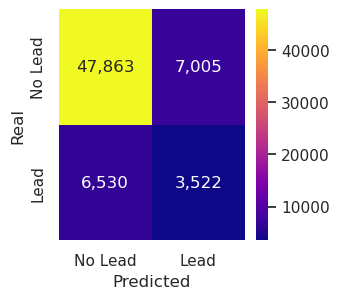

In [36]:
pmAccuracy=round(accuracy_score(y_test_original,y_pred),3)
pmRecall=round(recall_score(y_test_original,y_pred),3)
pmPrecision=round(precision_score(y_test_original,y_pred),3)
pmF1=round(f1_score(y_test, y_pred),3)
treesPerformances.loc[len(treesPerformances.index)] = ['Datos originales', pmAccuracy, pmRecall, pmPrecision, pmF1 ] 
print(f"Accuracy: {pmAccuracy}")
print(f"Recall: {pmRecall}")
print(f"Precision: {pmPrecision}")

target_labels = ['No Lead','Lead']
plt.figure(figsize=(3,3))
cm = confusion_matrix(y_test,y_pred)
ax = sns.heatmap(cm,cmap='plasma',annot=True, fmt='g',
            xticklabels=target_labels,
            yticklabels=target_labels)
ax.set(xlabel='Predicted',ylabel='Real')
for t in ax.texts: t.set_text('{:,d}'.format(int(float(t.get_text()))))
plt.show()

**Observaciones:**
    
Al parecer el hecho de que los ejemplos están desbalanceados affecta el desempeño del modelo. A continuación balancearemos los ejemplos por medio de sub/over sampling.


### Árboles de decisión con datos submuestreados  (1/2)

In [37]:
import imblearn

#Submuestreo

# lista los índices de Is_Lead
lead_idxs = data[data["Is_Lead"]==1].index.to_list()
print('Is_Lead == 1: ',len(lead_idxs))

# lista de índices que no son lead
nolead_idxs = data[data["Is_Lead"]==0].index.to_list()
print('Is_Lead == 0: ',len(nolead_idxs))

# seleccionamos aleatoriamente el doble de índices de no leads
random_nolead_idxs = np.random.choice(nolead_idxs, int(len(lead_idxs)*1.5), replace= False)
print('random picks len:',len(random_nolead_idxs))

# concatenamos los índices fraudulentos y normales y creamos el dataframe sub-sampleado
undersampled_indices = np.concatenate([lead_idxs, random_nolead_idxs])
undersampled_data = data.iloc[undersampled_indices,:]

print(f"Lead: {len(lead_idxs)}, Normales: {len(random_nolead_idxs)}")

print(f'Tamaño de data sin resampling: {data.shape}')
print(f'Tamaño de data luego de resampling: {undersampled_data.shape}')

Is_Lead == 1:  33313
Is_Lead == 0:  183087
random picks len: 49969
Lead: 33313, Normales: 49969
Tamaño de data sin resampling: (216400, 50)
Tamaño de data luego de resampling: (83282, 50)


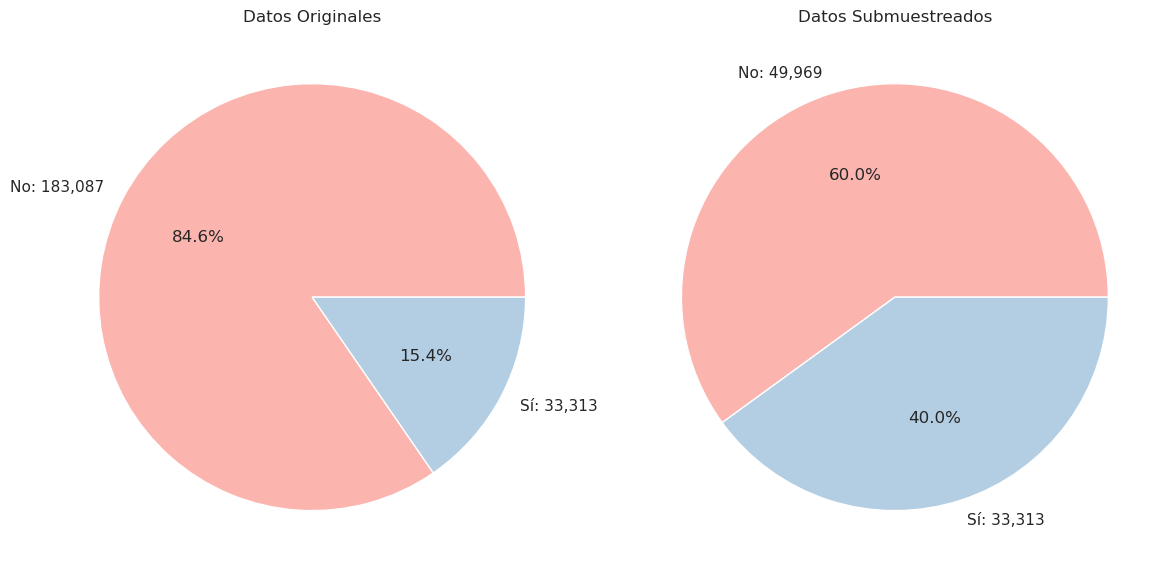

In [38]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

create_piechart_with_values(data.Is_Lead, 'Datos Originales',ax1,['No','Sí'])    
create_piechart_with_values(undersampled_data.Is_Lead, 'Datos Submuestreados',ax2,['No','Sí'])    

plt.tight_layout()
plt.show()

In [39]:
# "backup de data"
dataBkup = data.copy()

,importancia
feature,
Avg_Account_Balance,0.261
Credit_Product_Yes,0.164
Age,0.163
Vintage,0.135
Gender_Male,0.027
Occupation_Salaried,0.017
Is_Active_Yes,0.017
Region_Code_RG268,0.016
Region_Code_RG283,0.014


Accuracy: 0.658
Recall: 0.569
Precision: 0.572


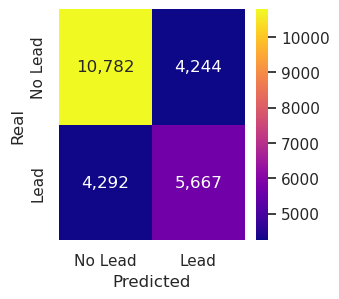

In [40]:
X = undersampled_data.drop('Is_Lead',axis=1)
y = undersampled_data['Is_Lead']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101) # 70% training and 30% test

clf = DecisionTreeClassifier()
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

importances_df = pd.DataFrame({'feature':list(X),'importancia':np.round(clf.feature_importances_,3)})
importances_df.sort_values(by='importancia',ascending=False,inplace=True)
display(importances_df.set_index('feature').head(10))

pmAccuracy=round(accuracy_score(y_test,y_pred),3)
pmRecall=round(recall_score(y_test,y_pred),3)
pmPrecision=round(precision_score(y_test,y_pred),3)
pmF1=round(f1_score(y_test, y_pred),3)
# no guardamos en df para metricas (haremos otro test con los datos originales, no los submuestreados)
print(f"Accuracy: {pmAccuracy}")
print(f"Recall: {pmRecall}")
print(f"Precision: {pmPrecision}")

target_labels = ['No Lead','Lead']
plt.figure(figsize=(3,3))
cm = confusion_matrix(y_test,y_pred)
ax = sns.heatmap(cm,cmap='plasma',annot=True, fmt='g',
            xticklabels=target_labels,
            yticklabels=target_labels)
ax.set(xlabel='Predicted',ylabel='Real')
for t in ax.texts: t.set_text('{:,d}'.format(int(float(t.get_text()))))
plt.show()



,importancia
feature,
Avg_Account_Balance,0.261
Credit_Product_Yes,0.164
Age,0.163
Vintage,0.135
Gender_Male,0.027
Occupation_Salaried,0.017
Is_Active_Yes,0.017
Region_Code_RG268,0.016
Region_Code_RG283,0.014


Accuracy: 0.786
Recall: 0.872
Precision: 0.41


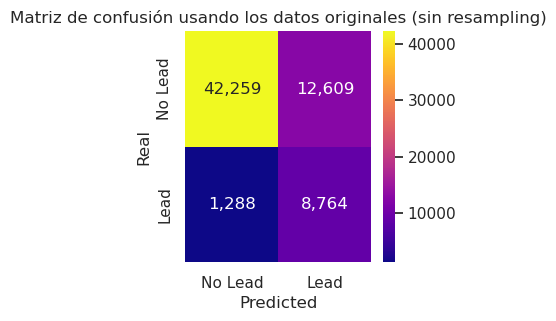

In [41]:
# test con los datos de prueba originales:
y_pred = clf.predict(X_test_original)

importances_df = pd.DataFrame({'feature':list(X),'importancia':np.round(clf.feature_importances_,3)})
importances_df.sort_values(by='importancia',ascending=False,inplace=True)
display(importances_df.set_index('feature').head(10))

pmAccuracy=round(accuracy_score(y_test_original,y_pred),3)
pmRecall=round(recall_score(y_test_original,y_pred),3)
pmPrecision=round(precision_score(y_test_original,y_pred),3)
pmF1=round(f1_score(y_test_original, y_pred),3)
treesPerformances.loc[len(treesPerformances.index)] = ['Sub-muestreo', pmAccuracy, pmRecall, pmPrecision, pmF1 ] 
print(f"Accuracy: {pmAccuracy}")
print(f"Recall: {pmRecall}")
print(f"Precision: {pmPrecision}")

target_labels = ['No Lead','Lead']
plt.figure(figsize=(3,3))
cm = confusion_matrix(y_test_original,y_pred)
ax = sns.heatmap(cm,cmap='plasma',annot=True, fmt='g',
            xticklabels=target_labels,
            yticklabels=target_labels)
ax.set(xlabel='Predicted',ylabel='Real')
for t in ax.texts: t.set_text('{:,d}'.format(int(float(t.get_text()))))
plt.title('Matriz de confusión usando los datos originales (sin resampling)')    
plt.show()

### Árboles de decisión con oversampling  (3/3)

In [42]:
# restauramos data
data=dataBkup.copy()



print('Datos de entrada a SMOTE:',data.shape)

oversample = SMOTE()

X = data.drop('Is_Lead',axis=1)
y = data['Is_Lead']
X_oversampled, y_oversampled = oversample.fit_resample(X, y)


print("Datos SMOTE originales X, y:", X.shape,y.shape)

# lista los índices sampleados
smoteSampleIdxs = X.index.to_list()
print('smoteSampleIdx:',len(smoteSampleIdxs))
randomSmoteSampleIdxs = np.random.choice(smoteSampleIdxs, int(len(smoteSampleIdxs)*SMOTE_FRACTION), replace= False)
X_oversampled = X.iloc[randomSmoteSampleIdxs,:]
y_oversampled = y.iloc[randomSmoteSampleIdxs]

print("Fracción de datos SMOTE utlizados:", SMOTE_FRACTION*100,'%')
print(f"Matriz de features: {X_oversampled.shape}")
print(f"Matriz de etiquetas: {y_oversampled.shape}")

from collections import Counter
print(Counter(y_oversampled))

Datos de entrada a SMOTE: (216400, 50)
Datos SMOTE originales X, y: (216400, 49) (216400,)
smoteSampleIdx: 216400
Fracción de datos SMOTE utlizados: 10.0 %
Matriz de features: (21640, 49)
Matriz de etiquetas: (21640,)
Counter({0: 18280, 1: 3360})


,importancia
feature,
Avg_Account_Balance,0.270
Vintage,0.161
Age,0.151
Credit_Product_Yes,0.098
Occupation_Salaried,0.030
Gender_Male,0.027
Is_Active_Yes,0.027
Region_Code_RG283,0.018
Channel_Code_X2,0.016


Accuracy: 0.788
Recall: 0.351
Precision: 0.336


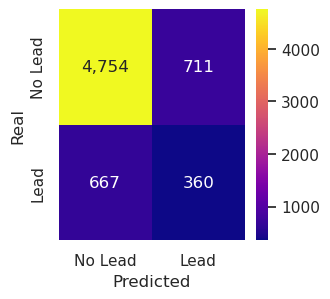

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X_oversampled, y_oversampled, test_size=0.3) # 70% training and 30% test

clf = DecisionTreeClassifier()
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

importances_df = pd.DataFrame({'feature':list(X),'importancia':np.round(clf.feature_importances_,3)})
importances_df.sort_values(by='importancia',ascending=False,inplace=True)
display(importances_df.set_index('feature').head(10))

pmAccuracy=round(accuracy_score(y_test,y_pred),3)
pmRecall=round(recall_score(y_test,y_pred),3)
pmPrecision=round(precision_score(y_test,y_pred),3)
pmF1=round(f1_score(y_test, y_pred),3)
# no guardamos en df de metricas, más adelante probaremos con los datos originales, no los sobremuestreados
print(f"Accuracy: {pmAccuracy}")
print(f"Recall: {pmRecall}")
print(f"Precision: {pmPrecision}")

target_labels = ['No Lead','Lead']
plt.figure(figsize=(3,3))
cm = confusion_matrix(y_test,y_pred)
ax = sns.heatmap(cm,cmap='plasma',annot=True, fmt='g',
            xticklabels=target_labels,
            yticklabels=target_labels)
ax.set(xlabel='Predicted',ylabel='Real')
for t in ax.texts: t.set_text('{:,d}'.format(int(float(t.get_text()))))
plt.show()



In [44]:
# falta visualización
viz = model(clf,
        tree_index=3,
        X_train=X_train,
        y_train=y_train,
        feature_names=list(X_train),
        target_name='Lead',
        class_names=['Lead','No Lead']
)

if LONG_TIME_CELLS:
    # no funciona
    # viz.view(scale=1.2,fontname='DejaVu Sans')
    pass


In [45]:
text_representation = tree.export_text(decision_tree=clf)
print(X_train.columns[9])
print(text_representation)


Credit_Product_Yes
|--- feature_9 <= 0.50
|   |--- feature_1 <= 68.50
|   |   |--- feature_1 <= 56.50
|   |   |   |--- feature_5 <= 0.50
|   |   |   |   |--- feature_0 <= 61.50
|   |   |   |   |   |--- feature_12 <= 0.50
|   |   |   |   |   |   |--- feature_14 <= 0.50
|   |   |   |   |   |   |   |--- feature_32 <= 0.50
|   |   |   |   |   |   |   |   |--- feature_33 <= 0.50
|   |   |   |   |   |   |   |   |   |--- feature_26 <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- feature_20 <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 37
|   |   |   |   |   |   |   |   |   |   |--- feature_20 >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 12
|   |   |   |   |   |   |   |   |   |--- feature_26 >  0.50
|   |   |   |   |   |   |   |   |   |   |--- feature_0 <= 42.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 7
|   |   |   |   |   |   |   |   |   |   |--- feature_0 >  42.50
|   |   |   | 

In [46]:
# falta visualización
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = list(X),class_names=['No Lead','Lead'])
#graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
#graph.write_png('cardleads-tree.png')
#Image(graph.create_png())

,importancia
feature,
Avg_Account_Balance,0.270
Vintage,0.161
Age,0.151
Credit_Product_Yes,0.098
Occupation_Salaried,0.030
Gender_Male,0.027
Is_Active_Yes,0.027
Region_Code_RG283,0.018
Channel_Code_X2,0.016


Accuracy: 0.805
Recall: 0.403
Precision: 0.378


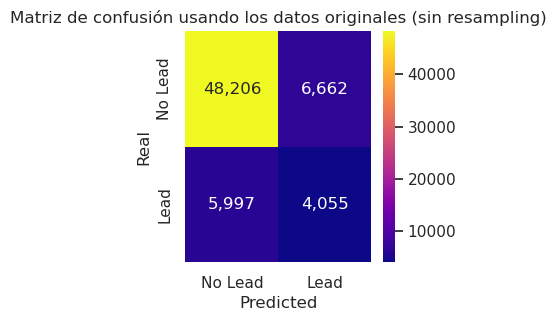

In [47]:
# test con los datos de prueba originales:
y_pred = clf.predict(X_test_original)

importances_df = pd.DataFrame({'feature':list(X),'importancia':np.round(clf.feature_importances_,3)})
importances_df.sort_values(by='importancia',ascending=False,inplace=True)
display(importances_df.set_index('feature').head(10))

pmAccuracy=round(accuracy_score(y_test_original,y_pred),3)
pmRecall=round(recall_score(y_test_original,y_pred),3)
pmPrecision=round(precision_score(y_test_original,y_pred),3)
pmF1=round(f1_score(y_test_original, y_pred),3)
treesPerformances.loc[len(treesPerformances.index)] = ['Sobre-muestreo', pmAccuracy, pmRecall, pmPrecision, pmF1 ] 
print(f"Accuracy: {pmAccuracy}")
print(f"Recall: {pmRecall}")
print(f"Precision: {pmPrecision}")

target_labels = ['No Lead','Lead']
plt.figure(figsize=(3,3))
cm = confusion_matrix(y_test_original,y_pred)
ax = sns.heatmap(cm,cmap='plasma',annot=True, fmt='g',
            xticklabels=target_labels,
            yticklabels=target_labels)
ax.set(xlabel='Predicted',ylabel='Real')
for t in ax.texts: t.set_text('{:,d}'.format(int(float(t.get_text()))))
plt.title('Matriz de confusión usando los datos originales (sin resampling)')    
plt.show()

### Comparación de métricas de rendimiento para los árboles de decisión usando diferentes datos

In [48]:
display(treesPerformances.sort_values(by='Acc', ascending=False))

,Data,Acc,Recall,Precision,F1
2,Sobre-muestreo,0.805,0.403,0.378,0.390
0,Datos originales,0.792,0.350,0.335,0.342
1,Sub-muestreo,0.786,0.872,0.410,0.558


## Búsqueda de componentes pricipales

Train data luego de reducción de dimensionalidad: (216400, 49)
Train data luego de reducción de dimensionalidad: (216400, 25)
El 70.0% de la varianza se obtiene con 7 componentes principales



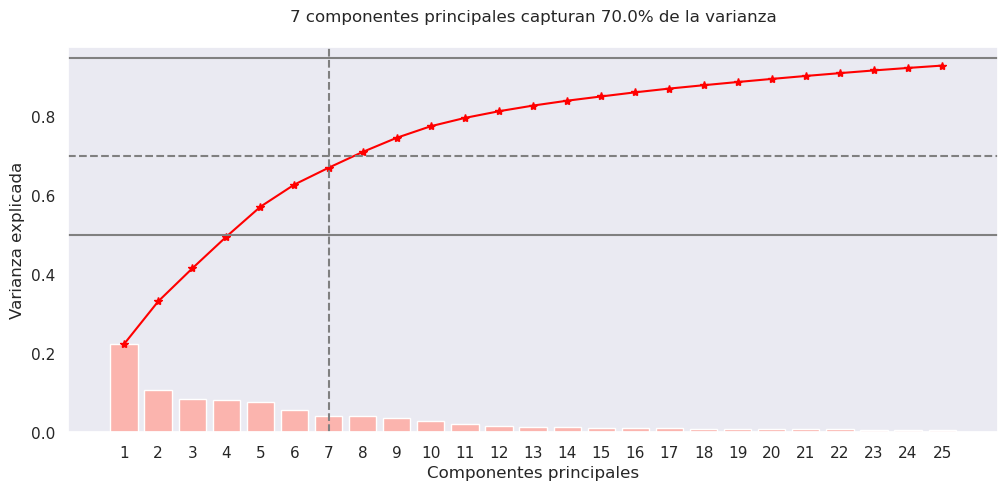

In [49]:
# restauramos data
data=dataBkup.copy()
X = data.drop('Is_Lead',axis=1)
y = data['Is_Lead']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101) # 70% training and 30% test

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=25)
X_red = pca.fit_transform(X_scaled)
#X_challenge_red = pca.transform(X_challenge_scaled)

print('Train data antes de reducción de dimensionalidad:',X.shape)
print('Train data luego de reducción de dimensionalidad:',X_red.shape)
#print('Test data luego de reducción de dimensionalidad:',X_challenge_red.shape)

xs = list(range(1, pca.explained_variance_ratio_.shape[0]+1))
capturedVarThreshold = .70

plt.figure(figsize=(12,5))
plt.bar(xs, pca.explained_variance_ratio_)
plt.xticks(xs)
plt.plot(xs, np.cumsum(pca.explained_variance_ratio_), '-*',color='red')
plt.grid()
plt.xlabel("Componentes principales")
plt.ylabel("Varianza explicada")

captured = np.cumsum(pca.explained_variance_ratio_)
#print(f"Varianza explicada por cada una de las componentes principales:\n{pca.explained_variance_ratio_}\n")
#print(f"Varianza acumulada explicada por cada una de las componentes principales:\n{captured)}\n")

plt.axhline(.5,color='gray',linestyle='-')
plt.axhline(.95,color='gray',linestyle='-')

maxPC = np.where(captured >= capturedVarThreshold)[0][0]
plt.axhline(capturedVarThreshold,color='gray',linestyle='--')
plt.axvline(maxPC,color='gray',linestyle='--')
#plt.xticks(rotation=80)

plt.title(f"{maxPC} componentes principales capturan {capturedVarThreshold*100}% de la varianza\n")

print(f"El {capturedVarThreshold*100}% de la varianza se obtiene con {maxPC} componentes principales\n")

### Preparación de pipeline y grid search para prueba de múltiples clasificadores con múltiples hiperparámetros

Usaremos los datos ~~submuestreados~~ sobremuestreados.

In [50]:
if DATA_TO_USE == 'over':
    X_train, X_test, y_train, y_test = train_test_split(X_oversampled, y_oversampled, test_size=0.3, random_state=101) # 70% training and 30% test
    X = X_oversampled
    y = y_oversampled
elif DATA_TO_USE == 'sub':
    X = undersampled_data.drop('Is_Lead',axis=1)
    y = undersampled_data['Is_Lead']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101) # 70% training and 30% test
elif DATA_TO_USE == 'orig':
    data = dataBkup.copy()
    X = data.drop('Is_Lead',axis=1)
    y = data['Is_Lead']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101) # 70% training and 30% test

print(f"Usando data: {DATA_TO_USE}")    
print('X_train: {:,d}, X_test: {:,d}, y_train: {:,d}, y_test: {:,d}'.format(X_train.shape[0],X_test.shape[0],y_train.shape[0],y_test.shape[0]))

Usando data: over
X_train: 15,148, X_test: 6,492, y_train: 15,148, y_test: 6,492


In [65]:
# dataframe para guardar performace metrics
classifiersPerformances = pd.DataFrame(columns=['Classifier','Data',
                                                'Acc','Recall','Precision','F1','Roc-Auc',
                                               ])

In [52]:
SCALER = True
POLY = False
DIMRED = True # si no hacemos dimRed el fitting toma demasiado tiempo
PCA_COMPONENTS = maxPC 

# CLASSIFIER /////////////////////(editar para cambiar el clasificador)/////////////////////
#classifier = RandomForestClassifier(n_jobs=-1)
classifier = SVC(probability=True)
#classifier =  RidgeClassifier()

# SCALER OBJECT
scaler = MinMaxScaler() if SCALER else None
#scaler = StandardScaler()

# POLYNOMIAL FEATURES OBJECT
poly = PolynomialFeatures(include_bias=True) if POLY else None

# DIMENSIONALITY REDUCTION OBJECT
dimRed = PCA(n_components=PCA_COMPONENTS) if DIMRED else None

# parámetros a probar con grid search:

# params for SVM:
#if type(classifier) == type(SVC()):
#    gridParams = [
#        {
#            'classifier__C': [.01,.1, 1, 10, 100, 1000],
#            'classifier__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
#            'classifier__gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
#            'poly__degree': [1,2,3]
#        },
#    ]
    

# Larger C values (e.g., 1, 10, 100) can be useful when:
#  The dataset is clean and has limited noise.
#  You want to capture complex decision boundaries.
#  You are willing to tolerate some misclassifications.

# Smaller gamma values (e.g., 0.001, 0.01) can be useful when:
#  The dataset is large.
#  The decision boundary is expected to be relatively smooth.
#  The classes are well-separated and the data is not too complex.

# params for SVM:
if type(classifier) == type(SVC()):
    gridParams = [
        {
            'classifier__C': [5, 10, 50],
            'classifier__kernel': ['poly', 'rbf', 'sigmoid'],
            'classifier__gamma': [.001,0.1, 0.5],
            'poly__degree': [1,3]
        },
    ]

# params for RandomForest:
if type(classifier) == type(RandomForestClassifier(n_jobs=-1)):
    gridParams = [
        {
            'classifier__n_estimators':[10,50,100]
        }]
    
# params for Linear(Ridge):
if type(classifier) == type(RidgeClassifier()):
    gridParams = [{
        'classifier__alpha':[.01,.1, 1,5,10],
    }]

# quitamos los parámetros que no se utilizarán
newParams = []
for d in gridParams:
    td = d.copy()
    for k in d.keys():
        if 'scaler' in k and not SCALER: del(td[k])
        if 'poly' in k and not POLY: del(td[k])
        if 'dimRed' in k and not DIMRED: del(td[k])
    newParams.append(td)
gridParams = newParams
            
# definimos los pasos del pipeline
steps=[
    ('scaler',scaler if scaler else 'passthrough'),
    ('dimRed', dimRed if dimRed else 'passthrough'),
    ('poly',poly if poly else 'passthrough'),
    ('classifier',classifier)
]

# quitamos del pipeline los pasos que no utilizaremos
steps = [s for s in steps if s[1]!='passthrough']
pipe = Pipeline(steps=steps)

# instanciamos un objeto de GridSearchCV
grid_search = GridSearchCV(
    estimator = pipe,
    param_grid = gridParams,
    scoring = 'accuracy',
    cv = 5, # incluimos cross validations en el grid search
    n_jobs = -1,
)

print('Steps to run:')
for s in [str(step) for step in pipe.steps]: print('\t',s)


Steps to run:
	 ('scaler', MinMaxScaler())
	 ('dimRed', PCA(n_components=7))
	 ('classifier', SVC(probability=True))


In [53]:
# fit the model and time it
start_time = time.time()
#print('inicio:',time.asctime())
printTime('inicio:')
grid_search = grid_search.fit(X_train, y_train)
end_time = time.time()
duration = end_time - start_time
#print('fin:',time.asctime())
printTime('fin:')
print('Tiempo para fit operations:',round((duration)/60,2),'minutos')
print('Datos usados:',DATA_TO_USE)
print('X_train: {:,d}, X_test: {:,d}, y_train: {:,d}, y_test: {:,d}'.format(X_train.shape[0],X_test.shape[0],y_train.shape[0],y_test.shape[0]))

inicio:  16:48:09
fin:  16:52:30
Tiempo para fit operations: 4.35 minutos
Datos usados: over
X_train: 15,148, X_test: 6,492, y_train: 15,148, y_test: 6,492


### Mejor estimador y métricas de rendimiento

Fracción de datos utlizados para set inicial de entrenamiento: 100 %

Datos usados para entrenamiento (originales, subsampled, oversampled): over
X_train: 15,148, X_test: 6,492, y_train: 15,148, y_test: 6,492

Tiempo para fit operations: 4.35 minutos

Componentes principales utlizados 7 (70.0% de la varianza)

Mejor accuracy gridSearch: 0.8525

Hiperparámetros del mejor modelo de gridsearch:
{'classifier__C': 5, 'classifier__gamma': 0.5, 'classifier__kernel': 'rbf'}

Pasos del pipeline:
	 ('scaler', MinMaxScaler())
	 ('dimRed', PCA(n_components=7))
	 ('classifier', SVC(probability=True))



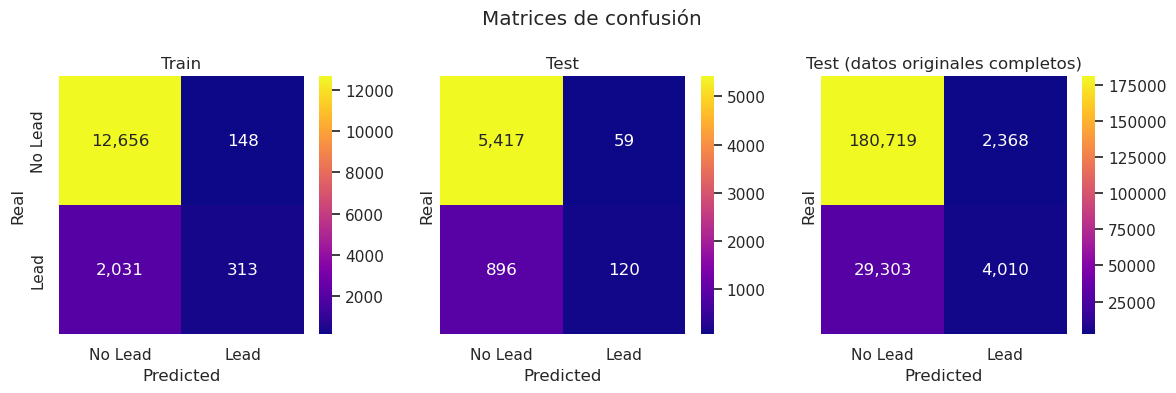

,Classifier,Data,Acc,Recall,Precision,F1,Roc-Auc
0,<class 'sklearn.svm._classes.SVC'>,Train,0.856,0.134,0.679,0.223,0.704198
1,<class 'sklearn.svm._classes.SVC'>,Test,0.853,0.118,0.670,0.201,0.652087
2,<class 'sklearn.svm._classes.SVC'>,Test Full,0.854,0.120,0.629,0.202,0.664389


In [66]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_train)

best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

print("Fracción de datos utlizados para set inicial de entrenamiento:", DATA_FRACTION*100,'%')
print()
print('Datos usados para entrenamiento (originales, subsampled, oversampled):',DATA_TO_USE)
print('X_train: {:,d}, X_test: {:,d}, y_train: {:,d}, y_test: {:,d}'.format(X_train.shape[0],X_test.shape[0],y_train.shape[0],y_test.shape[0]))
print()
print('Tiempo para fit operations:',round((duration)/60,2),'minutos')
print()
print("Componentes principales utlizados",maxPC,f'({capturedVarThreshold*100}% de la varianza)')
print()
print("Mejor accuracy gridSearch:", round(best_accuracy,4))
print()
print("Hiperparámetros del mejor modelo de gridsearch:")
print(best_parameters)
print()
print('Pasos del pipeline:')
for s in [str(step) for step in pipe.steps]: print('\t',s)
print()

# creamos un figura con tres subplots (train, test, test original)
target_labels = ['No Lead','Lead']
fig, axes = plt.subplots(1, 3, figsize=(12, 4),sharey=True)

# train
y_pred = best_model.predict(X_train)
y_pred_proba = best_model.predict_proba(X_train)[:, 1]
pmScoreTrain=round(best_model.score(X_train,y_train),3)
pmAccuracyTrain=round(accuracy_score(y_train,y_pred),3)
pmRecallTrain=round(recall_score(y_train,y_pred),3)
pmPrecisionTrain=round(precision_score(y_train,y_pred),3)
pmF1Train=round(f1_score(y_train,y_pred),3)
pmRocAucTrain = roc_auc_score(y_train, y_pred_proba)

cm = confusion_matrix(y_train,y_pred)
ax=axes[0]
sns.heatmap(cm,cmap='plasma',annot=True, fmt='g',xticklabels=target_labels,yticklabels=target_labels,ax=ax)
ax.set(xlabel='Predicted',ylabel='Real')
for t in ax.texts: t.set_text('{:,d}'.format(int(float(t.get_text()))))
ax.set_title('Train')

    
    
# test
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
pmScoreTest=round(best_model.score(X_test,y_test),3)
pmAccuracyTest=round(accuracy_score(y_test,y_pred),3)
pmRecallTest=round(recall_score(y_test,y_pred),3)
pmPrecisionTest=round(precision_score(y_test,y_pred),3)
pmF1Test=round(f1_score(y_test,y_pred),3)
pmRocAucTest = roc_auc_score(y_test, y_pred_proba)

cm = confusion_matrix(y_test,y_pred)
ax=axes[1]
sns.heatmap(cm,cmap='plasma',annot=True, fmt='g',xticklabels=target_labels,yticklabels=target_labels,ax=ax)
ax.set(xlabel='Predicted',ylabel='Real')
for t in ax.texts: t.set_text('{:,d}'.format(int(float(t.get_text()))))
ax.set_title('Test')




# test con los datos de prueba originales:
#y_pred = best_model.predict(X_test_original)
y_pred = best_model.predict(X_full)
y_pred_proba = best_model.predict_proba(X_full)[:, 1]
#pmScoreTestOrig=round(best_model.score(X_test_original,y_pred),3)
pmScoreTestOrig=round(best_model.score(X_full,y_full),3)
#pmAccuracyTestOrig=round(accuracy_score(y_test_original,y_pred),3)
pmAccuracyTestOrig=round(accuracy_score(y_full,y_pred),3)
#pmRecallTestOrig=round(recall_score(y_test_original,y_pred),3)
pmRecallTestOrig=round(recall_score(y_full,y_pred),3)
#pmPrecisionTestOrig=round(precision_score(y_test_original,y_pred),3)
pmPrecisionTestOrig=round(precision_score(y_full,y_pred),3)
#pmF1TestOrig=round(f1_score(y_test_original, y_pred),3)
pmF1TestOrig=round(f1_score(y_full, y_pred),3)
pmRocAucTestOrig = roc_auc_score(y_full, y_pred_proba)

#cm = confusion_matrix(y_test_original,y_pred)
cm = confusion_matrix(y_full,y_pred)
ax=axes[2]
sns.heatmap(cm,cmap='plasma',annot=True, fmt='g',xticklabels=target_labels,yticklabels=target_labels,ax=ax)
ax.set(xlabel='Predicted',ylabel='Real')
for t in ax.texts: t.set_text('{:,d}'.format(int(float(t.get_text()))))
ax.set_title('Test (datos originales completos)')

plt.suptitle('Matrices de confusión')
plt.tight_layout()
plt.show()

classifiersPerformances.loc[len(classifiersPerformances.index)] = [type(pipe['classifier']),'Train',
                                                                  pmAccuracyTrain, pmRecallTrain, pmPrecisionTrain, pmF1Train,pmRocAucTrain
                                                                  ] 

classifiersPerformances.loc[len(classifiersPerformances.index)] = [type(pipe['classifier']),'Test',
                                                                  pmAccuracyTest, pmRecallTest, pmPrecisionTest, pmF1Test,pmRocAucTest
                                                                  ] 

classifiersPerformances.loc[len(classifiersPerformances.index)] = [type(pipe['classifier']),'Test Full',
                                                                  pmAccuracyTestOrig, pmRecallTestOrig, pmPrecisionTestOrig, pmF1TestOrig,pmRocAucTestOrig
                                                                  ] 

display(classifiersPerformances)

if type(classifier) == type(RandomForestClassifier(n_jobs=-1)):
    if SCALER:
        X_train_scaled = scaler.fit_transform(X_train)
        X_train = X_train_scaled
        
    if DIMRED:
        pca = PCA(n_components=maxPC)
        X_train_red = pca.fit_transform(X_train)
        X_train = X_train_red
    
    feature_cols = pd.DataFrame(X_train_red).columns.to_list()
    classifier.fit(X_train,y_train)
    
    importances = pd.DataFrame({'feature':feature_cols,'importancia':np.round(classifier.feature_importances_,3)})
    importances.sort_values(by='importancia',ascending=False,inplace=True)
    importances.set_index('feature')
    print(importances)



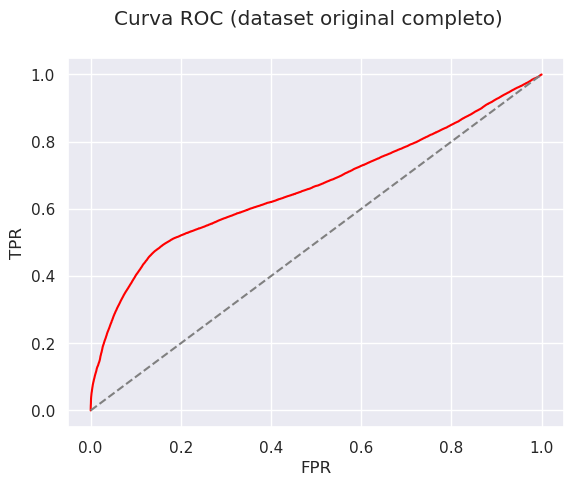

In [71]:
fpr, tpr, thresholds = roc_curve(y_full, y_pred_proba)

plt.figure()
plt.suptitle("Curva ROC (dataset original completo)") 
plt.plot(fpr,tpr,color='red')
plt.plot([0,1],[0,1],linestyle='--',color='gray')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

### Clustering con DBSCAN

In [109]:
modelo = DBSCAN(eps=150, min_samples=12)
yhat = modelo.fit_predict(X)
clusters = [j for j in np.unique(yhat) if j!=-1]
print(clusters)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73]


21640

Clientes que no fueron agregados a un cluster: 0 / 21640


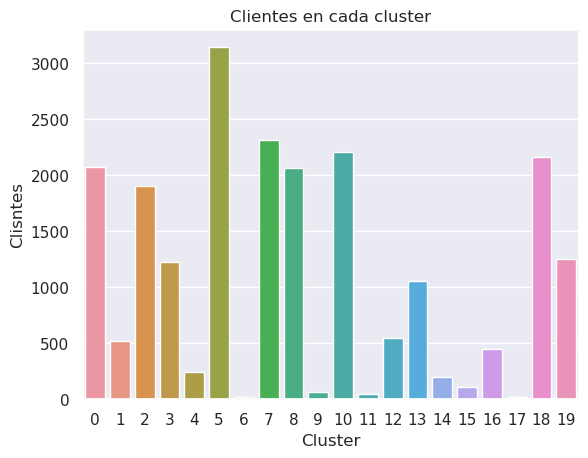

El total de clientes en clusters es de: 21640
Estadísticas descriptivas del cluster 6:


,Age,Vintage,Avg_Account_Balance,Gender_Male,Occupation_Entrepreneur,Occupation_Other,Occupation_Salaried,Occupation_Self_Employed,Is_Active_Yes,Credit_Product_Yes,...,Region_Code_RG277,Region_Code_RG278,Region_Code_RG279,Region_Code_RG280,Region_Code_RG281,Region_Code_RG282,Region_Code_RG283,Region_Code_RG284,Is_Lead,Cluster
count,21.000000,21.000000,2.100000e+01,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,...,21.0,21.0,21.0,21.0,21.0,21.0,21.000000,21.000000,21.000000,21.0
mean,44.000000,45.428571,8.769129e+06,0.809524,0.047619,0.571429,0.142857,0.238095,0.476190,0.523810,...,0.0,0.0,0.0,0.0,0.0,0.0,0.190476,0.142857,0.142857,6.0
std,17.412639,36.935852,5.783694e+05,0.402374,0.218218,0.507093,0.358569,0.436436,0.511766,0.511766,...,0.0,0.0,0.0,0.0,0.0,0.0,0.402374,0.358569,0.358569,0.0
min,24.000000,13.000000,8.171008e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,6.0
25%,27.000000,15.000000,8.344738e+06,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,6.0
50%,42.000000,25.000000,8.632721e+06,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,6.0
75%,58.000000,68.000000,9.000069e+06,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,6.0
max,74.000000,123.000000,1.035201e+07,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,1.000000,1.000000,6.0


In [206]:
XWithYAndCluster = pd.concat((X.reset_index(drop=True),y.reset_index(drop=True),pd.DataFrame(yhat,columns=['Cluster'])), axis=1)

print("Clientes que no fueron agregados a un cluster:",XWithYAndCluster[XWithYAndCluster.Cluster==-1].shape[0],'/',XWithYAndCluster.shape[0])

clientesEnClustersTotales=0
clientesEnClusters=[]
for cluster in clusters:
    clientesEnClusters.append( XWithYAndCluster[XWithYAndCluster.Cluster==cluster].shape[0] )
    clientesEnClustersTotales += XWithYAndCluster[XWithYAndCluster.Cluster==cluster].shape[0]

plt.figure(figsize=(10,5))
sns.barplot(x=np.arange(len(clientesEnClusters)), y=clientesEnClusters)
plt.xlabel("Cluster")
plt.ylabel("Clisntes")
plt.title("Clientes en cada cluster")
plt.show()

print('El total de clientes en clusters es de:',clientesEnClustersTotales)
#display(XWithYAndCluster.head())
print('Estadísticas descriptivas del cluster 6:')
display(XWithYAndCluster[XWithYAndCluster.Cluster==6].describe())



**Observaciones:**

Los clientes dentro de cada cluster deben tener características similares. Revisando las desviaciones estándar de cada feature podemos hacernos cierta idea de las features que comparten:

#### Desviación estándar de cada feature de los datos del un par de clusters:

In [204]:
clusterNumber = 5
stds=XWithYAndCluster[(XWithYAndCluster.Cluster==clusterNumber)]
stds.describe().loc['std'].sort_values()

Cluster                         0.000000
Occupation_Entrepreneur         0.059047
Region_Code_RG262               0.066582
Region_Code_RG253               0.068907
Region_Code_RG271               0.092272
Region_Code_RG265               0.097216
Region_Code_RG278               0.100372
Region_Code_RG255               0.104921
Region_Code_RG275               0.112075
Region_Code_RG266               0.113449
Region_Code_RG276               0.114806
Region_Code_RG250               0.117470
Region_Code_RG267               0.120071
Region_Code_RG258               0.126326
Region_Code_RG282               0.133421
Region_Code_RG256               0.139037
Region_Code_RG263               0.140131
Region_Code_RG264               0.144418
Region_Code_RG259               0.145468
Region_Code_RG279               0.147543
Region_Code_RG260               0.148569
Region_Code_RG274               0.149588
Region_Code_RG272               0.156512
Region_Code_RG281               0.161257
Channel_Code_X4 

In [202]:
clusterNumber = 9
stds=XWithYAndCluster[(XWithYAndCluster.Cluster==clusterNumber)]
stds.describe().loc['std'].sort_values()

Cluster                          0.000000
Region_Code_RG265                0.000000
Region_Code_RG264                0.000000
Region_Code_RG263                0.000000
Region_Code_RG262                0.000000
Region_Code_RG260                0.000000
Region_Code_RG259                0.000000
Region_Code_RG258                0.000000
Region_Code_RG256                0.000000
Region_Code_RG255                0.000000
Region_Code_RG270                0.000000
Region_Code_RG271                0.000000
Region_Code_RG252                0.000000
Region_Code_RG250                0.000000
Region_Code_RG251                0.000000
Region_Code_RG278                0.000000
Region_Code_RG282                0.000000
Region_Code_RG281                0.000000
Occupation_Entrepreneur          0.000000
Region_Code_RG279                0.000000
Channel_Code_X4                  0.000000
Region_Code_RG267                0.000000
Region_Code_RG276                0.000000
Region_Code_RG275                0

### Clustering con Jerárquico usando PCA

In [302]:
# TODO: remove these X and y assigns (already in appropiate cell):
#X = X_oversampled
#y = y_oversampled

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=2)
X_red = pca.fit_transform(X_scaled)

explained_variance_ratios = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratios)
for i in range(2):
    print(f"Varianza explicada para el componente {i+1}: {explained_variance_ratios[i]}")
print(f"Varianza acumulada para {2} componentes: {cumulative_variance[2-1]}")

modelo = AgglomerativeClustering(distance_threshold=5.0,
                                 n_clusters=None,
                                 compute_full_tree=True)

#modelo = DBSCAN(eps=5000, min_samples=50) # no logré un clustering con DBSCAN sobre este dataset

yhat = modelo.fit_predict(X_red)
clusters = [j for j in np.unique(yhat) if j!=-1]
print("Clusters:")
print(clusters)


Varianza explicada para el componente 1: 0.22203880803749249
Varianza explicada para el componente 2: 0.10889360171389989
Varianza acumulada para 2 componentes: 0.3309324097513924
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]


**Observaciones:**

No logré un clustering sobre estos datos usando DBSCAN

Clientes que no fueron agregados a un cluster: 0 / 21640


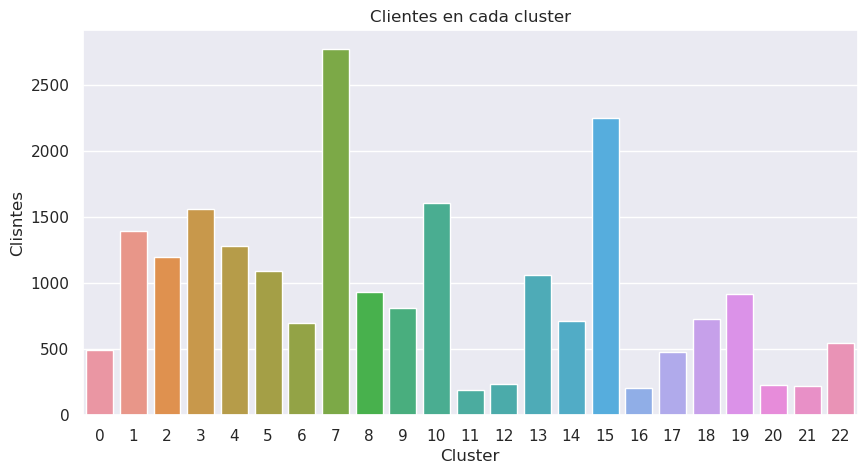

El total de clientes en clusters es de: 21640
Estadísticas descriptivas del cluster 6:


,Age,Vintage,Avg_Account_Balance,Gender_Male,Occupation_Entrepreneur,Occupation_Other,Occupation_Salaried,Occupation_Self_Employed,Is_Active_Yes,Credit_Product_Yes,...,Region_Code_RG277,Region_Code_RG278,Region_Code_RG279,Region_Code_RG280,Region_Code_RG281,Region_Code_RG282,Region_Code_RG283,Region_Code_RG284,Is_Lead,Cluster
count,699.000000,699.000000,6.990000e+02,699.000000,699.0,699.0,699.0,699.0,699.000000,699.000000,...,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.0
mean,47.015737,34.927039,1.312107e+06,0.692418,0.0,1.0,0.0,0.0,0.453505,0.522175,...,0.034335,0.004292,0.008584,0.034335,0.020029,0.020029,0.203147,0.108727,0.108727,6.0
std,20.462028,22.440985,1.008383e+06,0.461823,0.0,0.0,0.0,0.0,0.498190,0.499866,...,0.182218,0.065418,0.092316,0.182218,0.140198,0.140198,0.402629,0.311519,0.311519,0.0
min,24.000000,7.000000,1.172840e+05,0.000000,0.0,1.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.0
25%,28.000000,19.000000,6.834710e+05,0.000000,0.0,1.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.0
50%,38.000000,26.000000,1.065623e+06,1.000000,0.0,1.0,0.0,0.0,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.0
75%,67.000000,50.000000,1.601274e+06,1.000000,0.0,1.0,0.0,0.0,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.0
max,85.000000,99.000000,8.632721e+06,1.000000,0.0,1.0,0.0,0.0,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,6.0


In [307]:
XWithYAndCluster = pd.concat((X.reset_index(drop=True),y.reset_index(drop=True),pd.DataFrame(yhat,columns=['Cluster'])), axis=1)

print("Clientes que no fueron agregados a un cluster:",XWithYAndCluster[XWithYAndCluster.Cluster==-1].shape[0],'/',XWithYAndCluster.shape[0])

clientesEnClustersTotales=0
clientesEnClusters=[]
for cluster in clusters:
    clientesEnClusters.append( XWithYAndCluster[XWithYAndCluster.Cluster==cluster].shape[0] )
    clientesEnClustersTotales += XWithYAndCluster[XWithYAndCluster.Cluster==cluster].shape[0]

plt.figure(figsize=(10,5))
sns.barplot(x=np.arange(len(clientesEnClusters)), y=clientesEnClusters)
plt.xlabel("Cluster")
plt.ylabel("Clisntes")
plt.title("Clientes en cada cluster")
plt.show()

print('El total de clientes en clusters es de:',clientesEnClustersTotales)
#display(XWithYAndCluster.head())
print('Estadísticas descriptivas del cluster 6:')
display(XWithYAndCluster[XWithYAndCluster.Cluster==6].describe())


#### Desviación estándar de cada feature de un cluster:

In [310]:
clusterNumber = 7
stds=XWithYAndCluster[(XWithYAndCluster.Cluster==clusterNumber)]
stds.describe().loc['std'].sort_values()

Cluster                          0.000000
Occupation_Entrepreneur          0.000000
Occupation_Other                 0.000000
Occupation_Salaried              0.000000
Occupation_Self_Employed         0.000000
Channel_Code_X4                  0.000000
Channel_Code_X1                  0.000000
Channel_Code_X2                  0.000000
Channel_Code_X3                  0.000000
Region_Code_RG253                0.046424
Region_Code_RG278                0.059890
Region_Code_RG265                0.073283
Region_Code_RG255                0.084544
Region_Code_RG276                0.094437
Region_Code_RG266                0.094437
Region_Code_RG262                0.094437
Region_Code_RG267                0.096290
Region_Code_RG259                0.105046
Region_Code_RG258                0.108342
Region_Code_RG271                0.109951
Region_Code_RG250                0.111536
Region_Code_RG279                0.116154
Region_Code_RG263                0.127611
Region_Code_RG260                0

**Observaciones:**

Podríamos encontrar qué cluster se basa más en cierta feature, Vintage, por ejemplo si comparamos la desviación estándar de cada cluster y encontramos cuál cluster tiene menos.

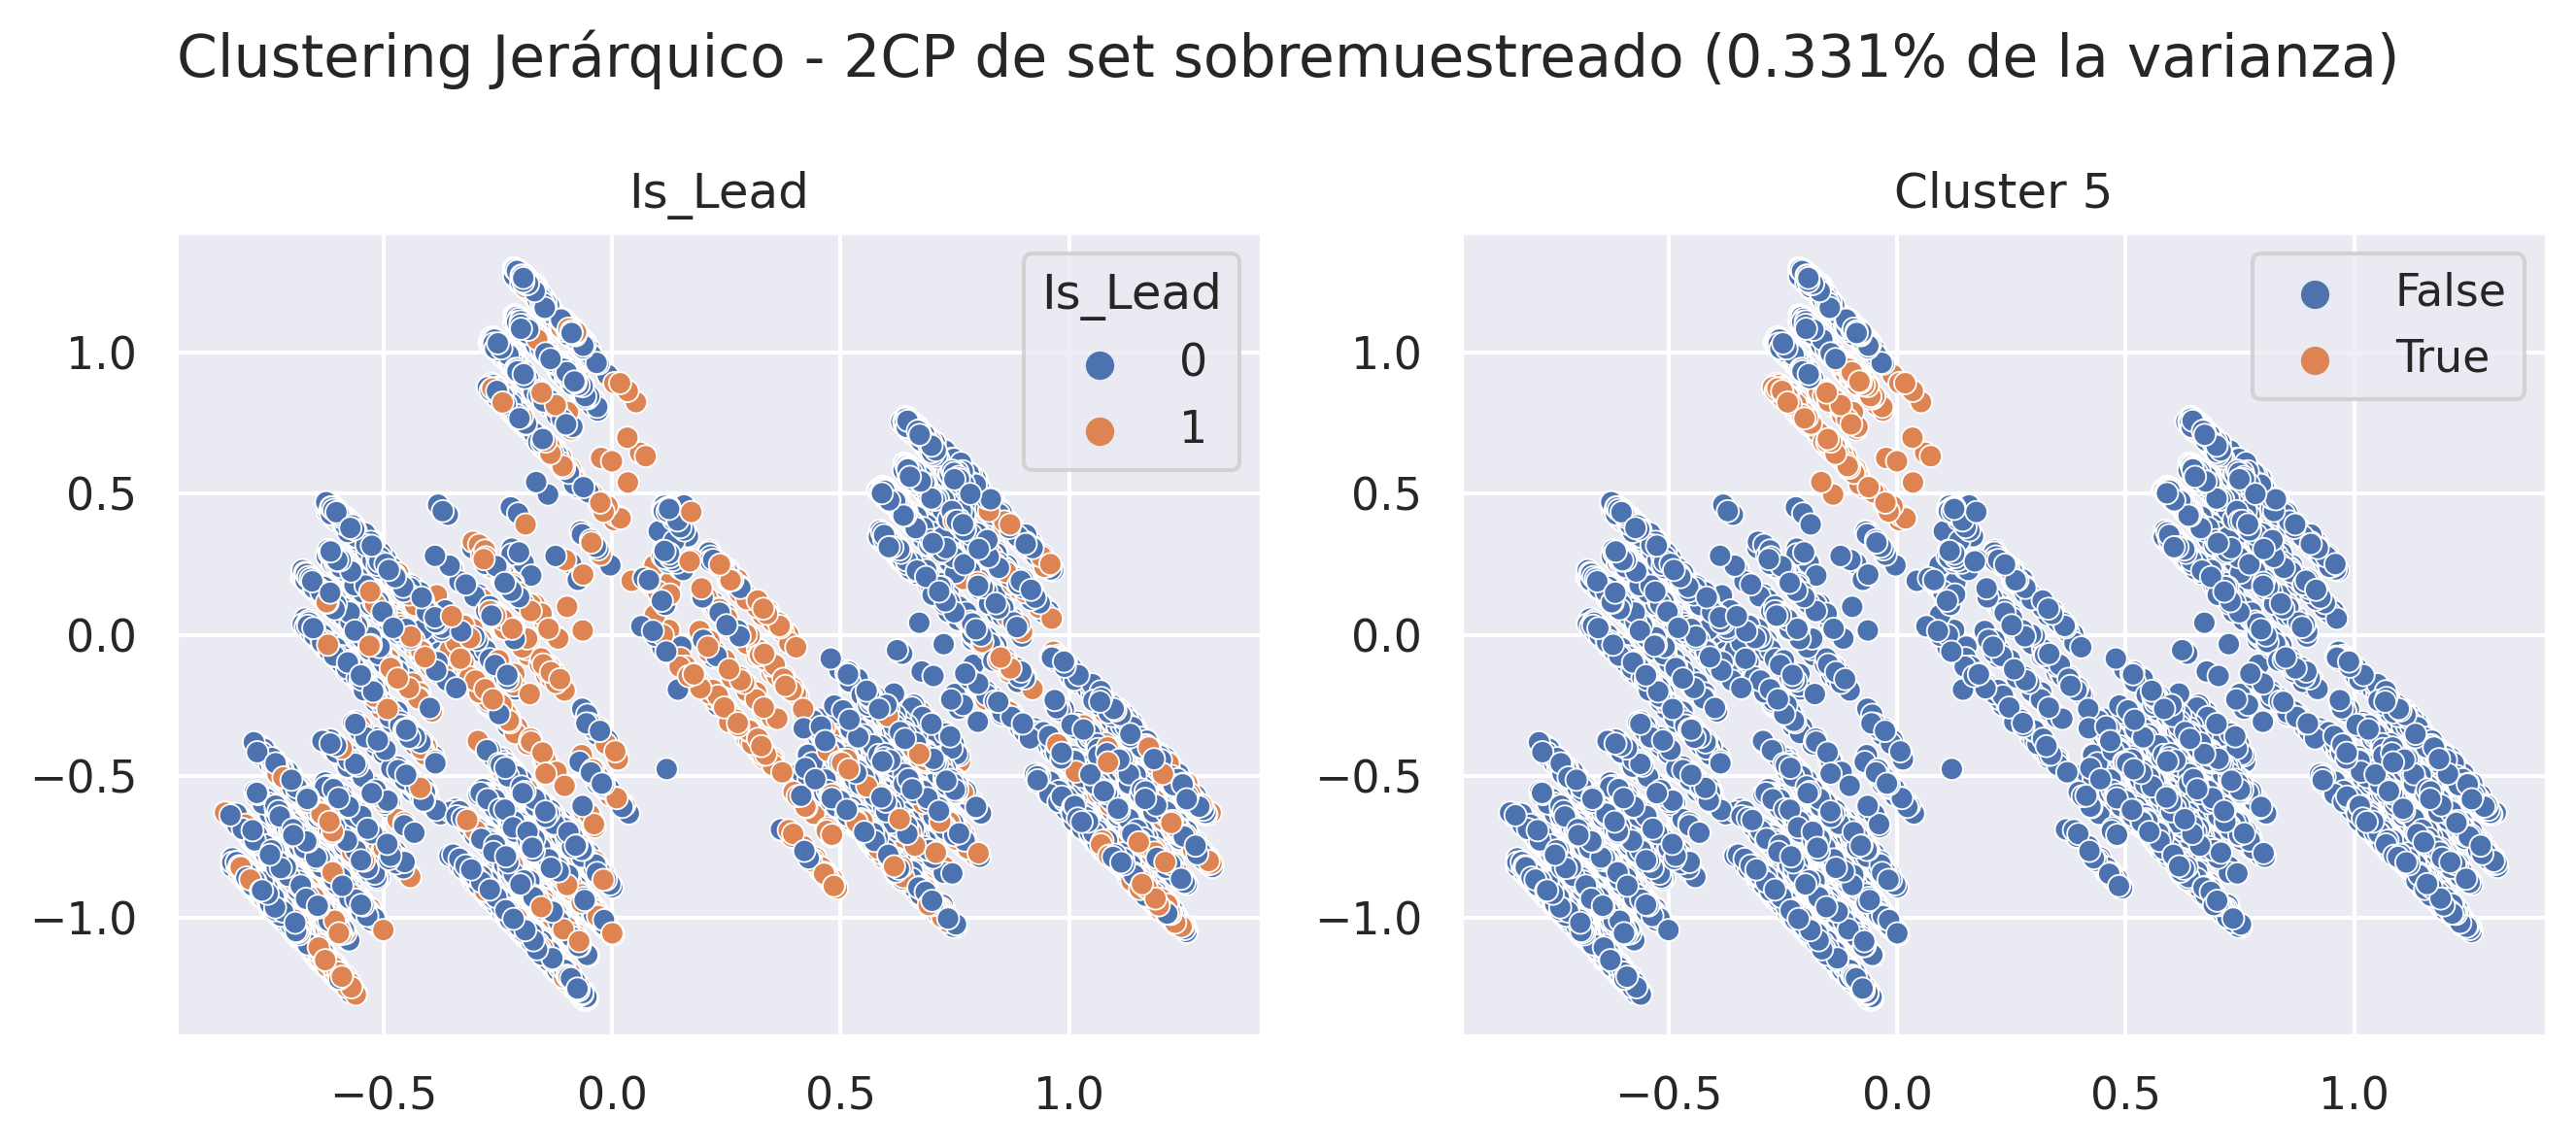

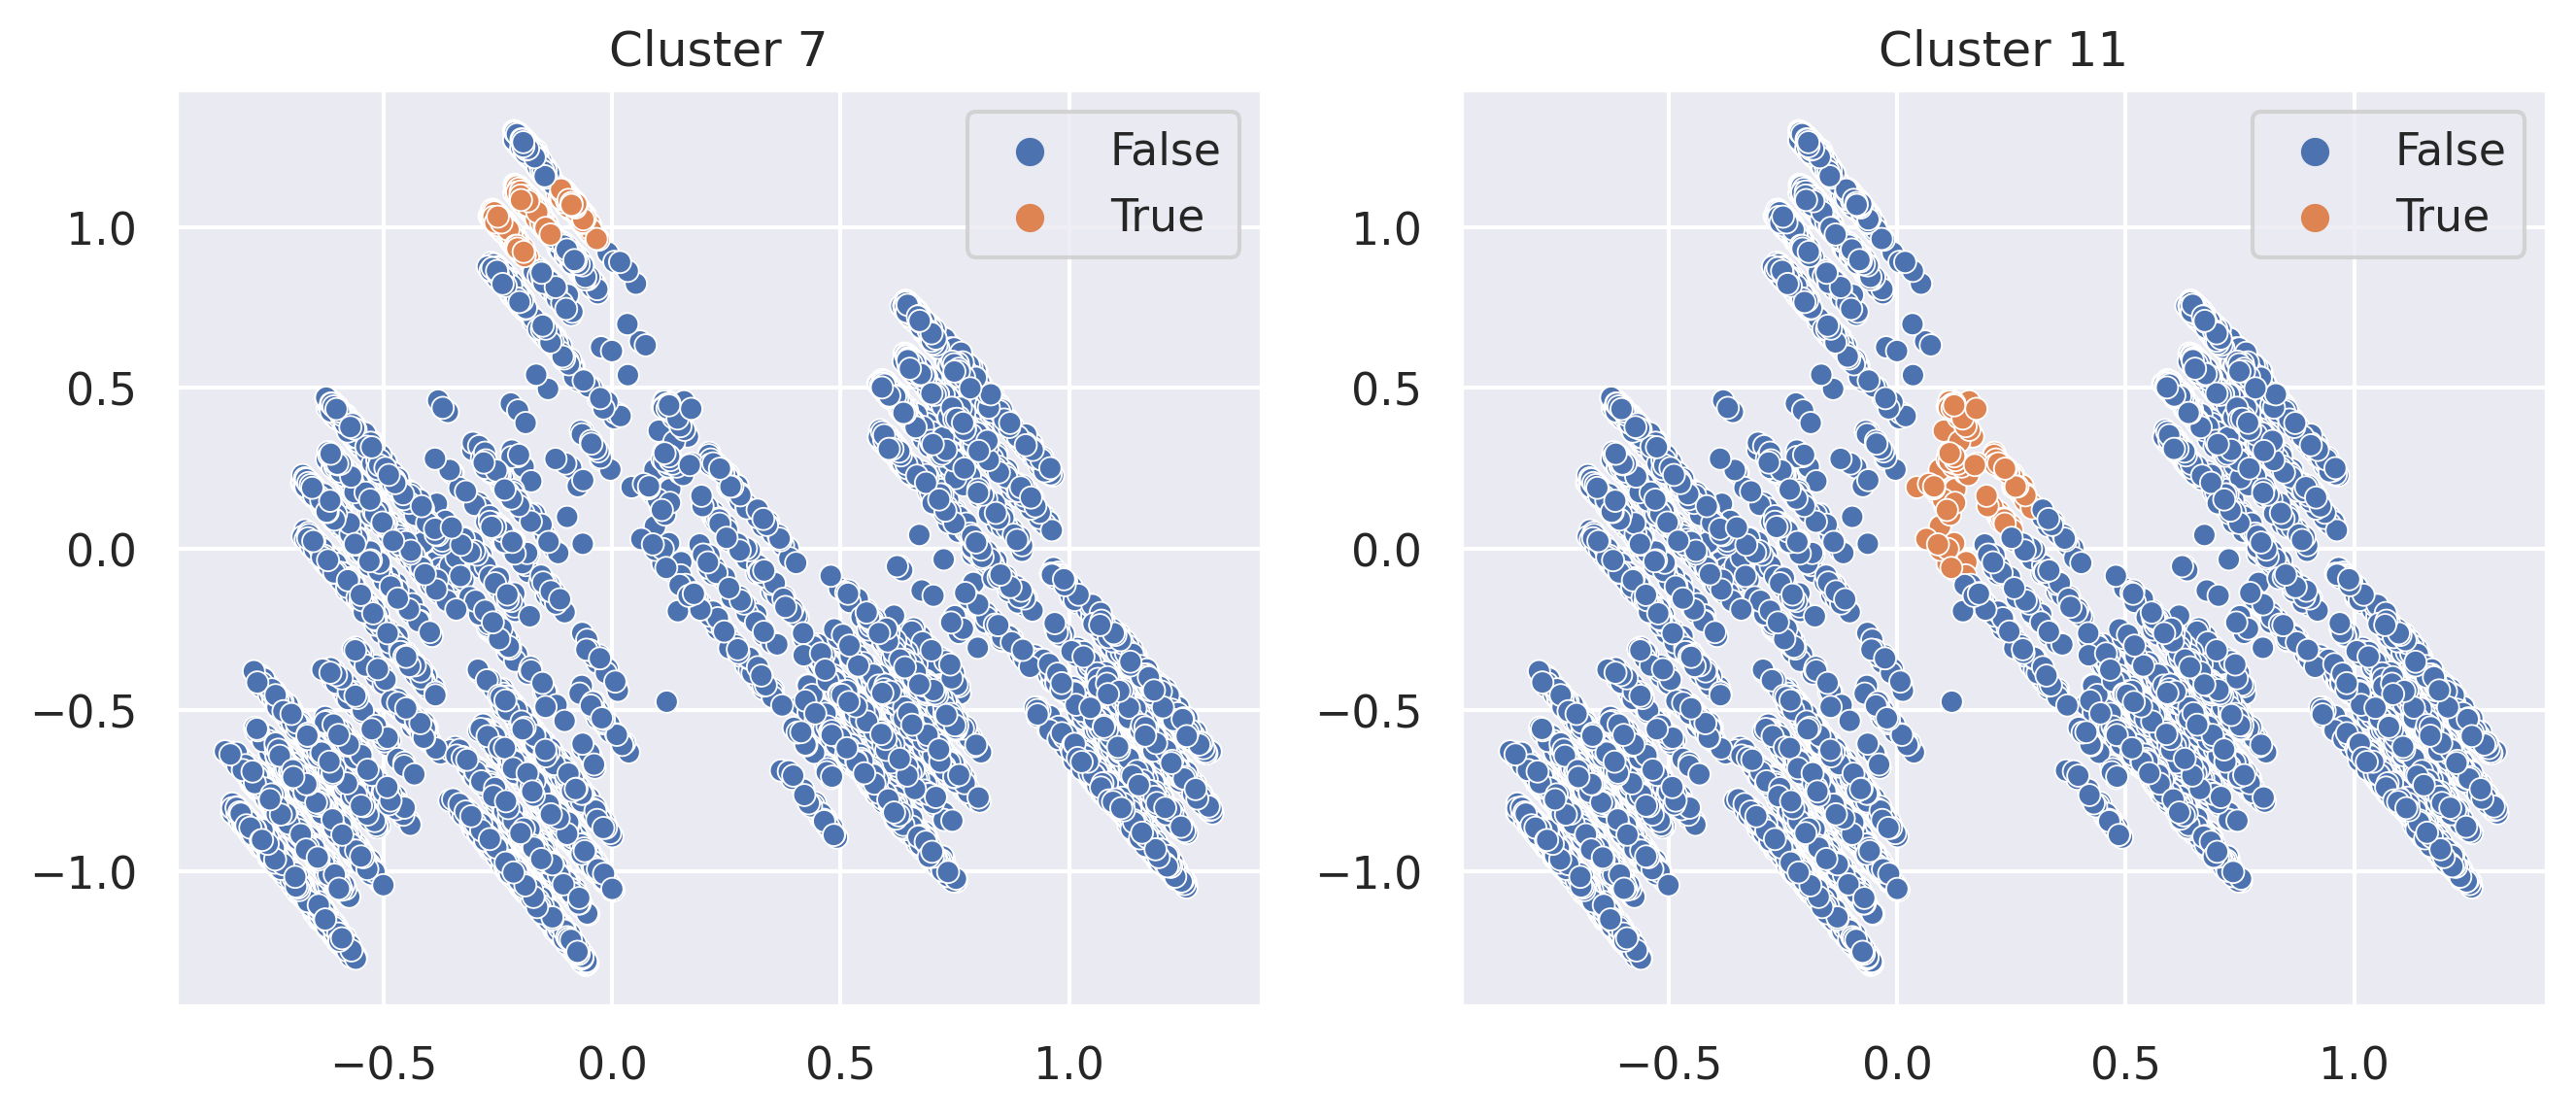

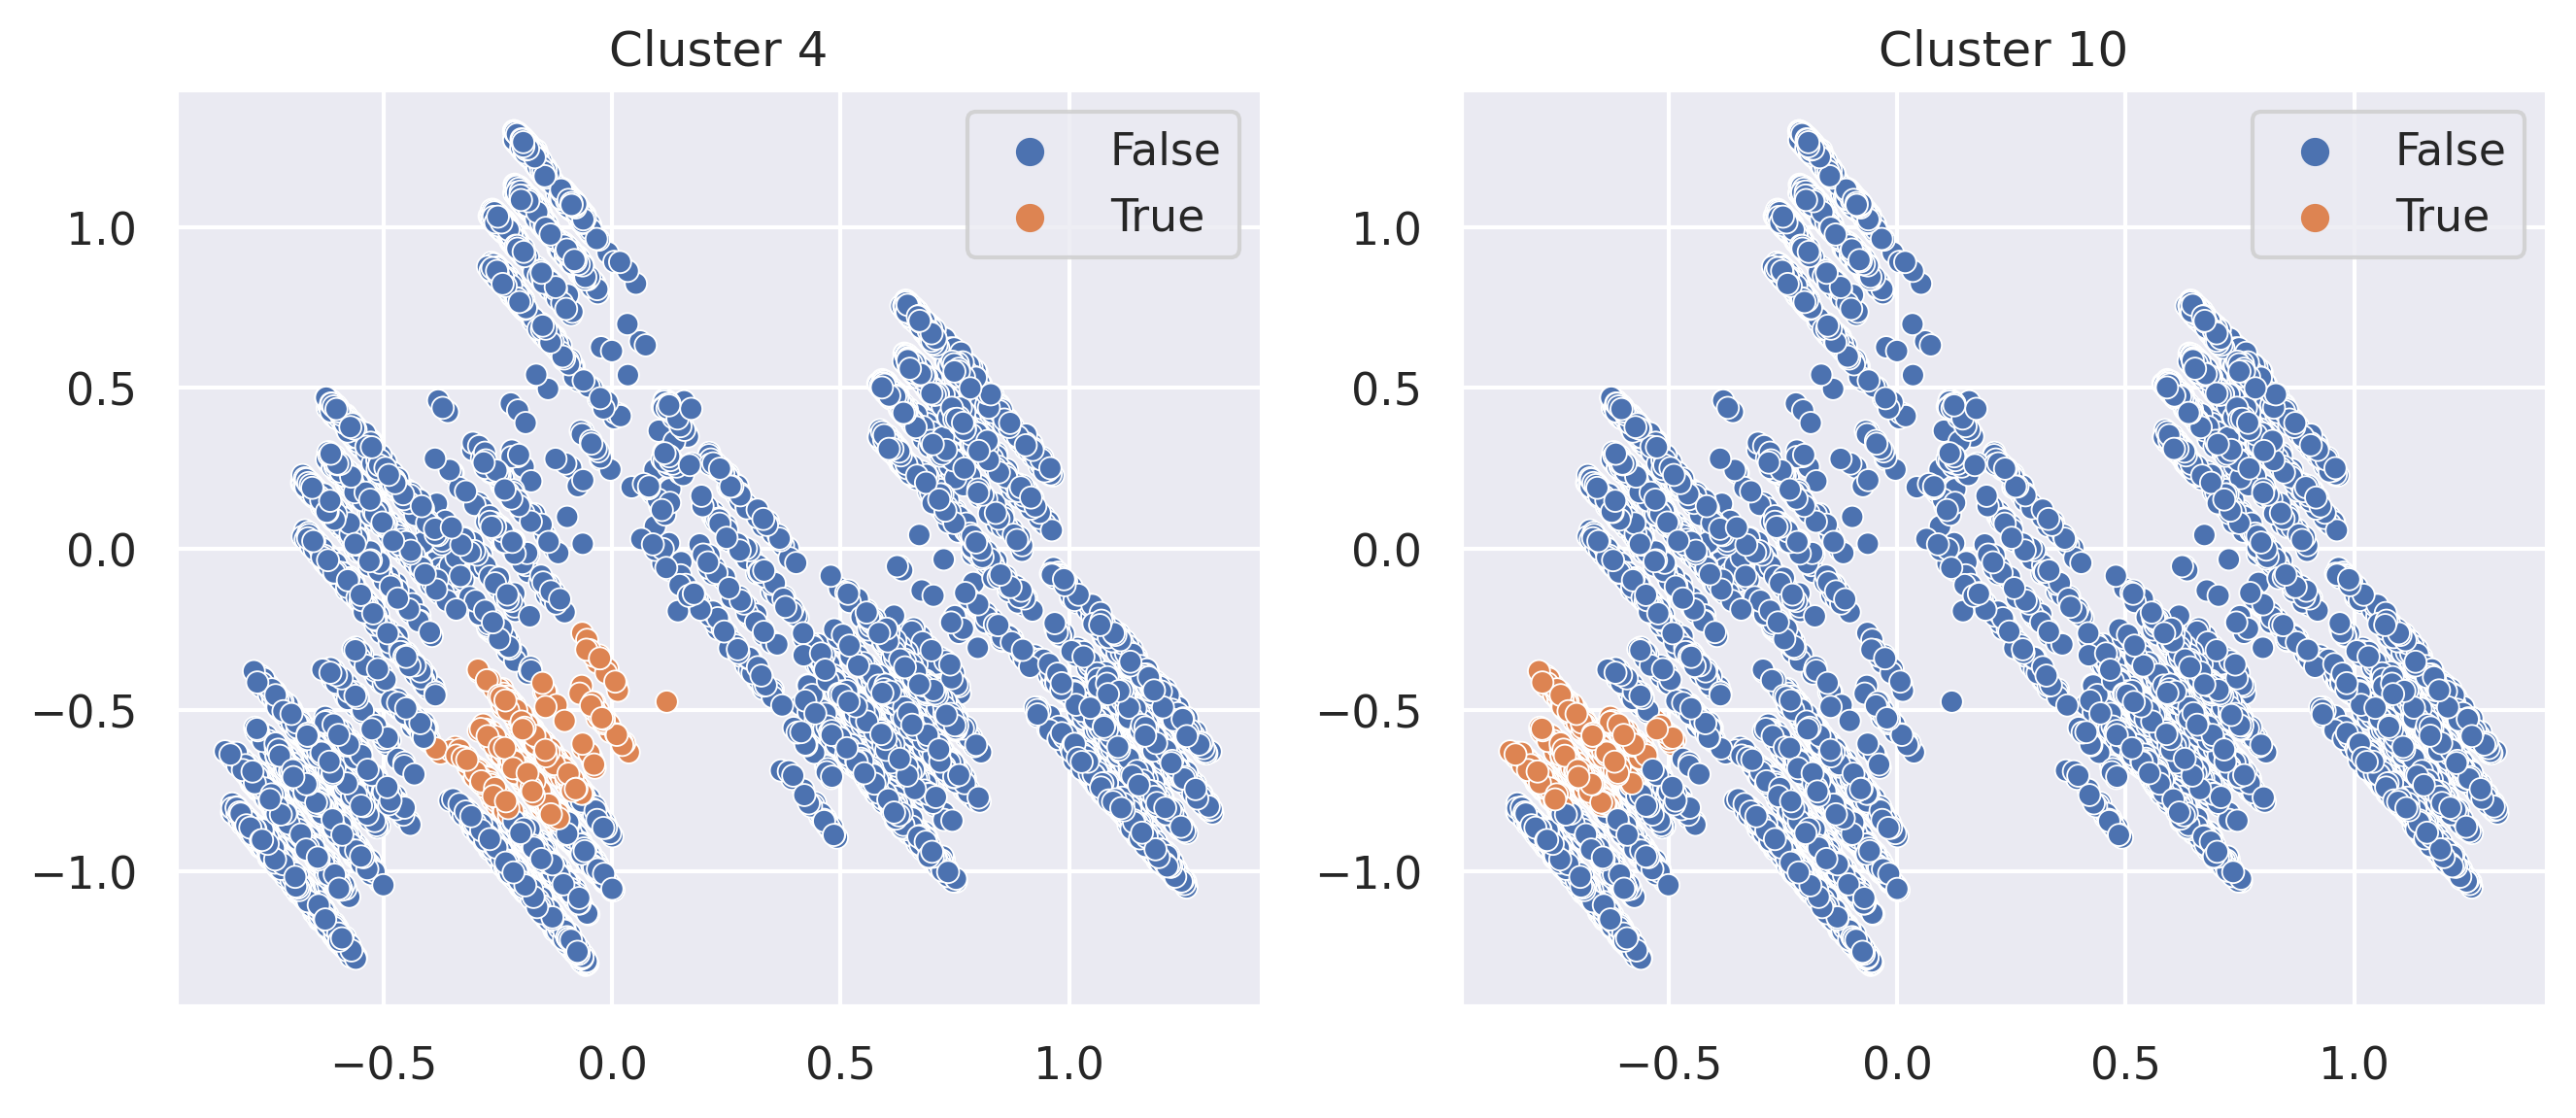

In [306]:
# plotting de clusters
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 4),dpi=300)
sns.scatterplot(x = X_red[:,1], y = X_red[:,0], hue = y, palette='deep', ax=axes[0], s=30)
axes[0].set_title('Is_Lead')
sns.scatterplot(x = X_red[:,1], y = X_red[:,0], hue = yhat==5, palette='deep', ax=axes[1], s=30)
axes[1].set_title('Cluster 5')
plt.suptitle(f'Clustering Jerárquico con 2CP ({round(cumulative_variance[-1],3)}% de la varianza)')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 4),dpi=300)
sns.scatterplot(x = X_red[:,1], y = X_red[:,0], hue = yhat==7, palette='deep', ax=axes[0], s=30)
axes[0].set_title('Cluster 7')
sns.scatterplot(x = X_red[:,1], y = X_red[:,0], hue = yhat==11, palette='deep', ax=axes[1], s=30)
axes[1].set_title('Cluster 11')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 4),dpi=300)
sns.scatterplot(x = X_red[:,1], y = X_red[:,0], hue = yhat==4, palette='deep', ax=axes[0], s=30)
axes[0].set_title('Cluster 4')
sns.scatterplot(x = X_red[:,1], y = X_red[:,0], hue = yhat==10, palette='deep', ax=axes[1], s=30)
axes[1].set_title('Cluster 10')
plt.tight_layout()
plt.show()